In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
### Basic Loads 
users = pd.read_csv('users.csv', parse_dates=['signup_date'])
sessions = pd.read_csv('sessions.csv', parse_dates=['session_start','session_end'])
events = pd.read_csv('events.csv', parse_dates=['ts'])
billing = pd.read_csv('billing.csv', parse_dates=['month'])

In [3]:
### Sanity Checks

## Counts 
print(len(users), len(sessions), len(events), len(billing))

## Missingness
print(users.isnull().sum())
print(sessions.isnull().sum())
print(events.isnull().sum())
print(billing.isnull().sum())

# CHANGE: Flag region_missing binary column, then fill missing regions with unknown
users['region_missing'] = users['region'].isnull().astype(int) 
users['region'].fillna('unknown', inplace=True) # 38224 missing

# CHANGE: Use mode imputation for app_version 
mode_version = sessions['app_version'].mode()[0]
sessions['app_version'].fillna(mode_version, inplace=True) # 4935 missing

## Duplicate primary keys
print("Duplicate users:", users['user_id'].duplicated().sum())
print("Duplicate sessions:", sessions['session_id'].duplicated().sum())
print("Duplicate events:", events['event_id'].duplicated().sum())
print("Duplicate billing:", billing[['user_id','month']].duplicated().sum())

## Min/max date column checks
print("Users signup_date:", users['signup_date'].min(), "-", users['signup_date'].max())
print("Sessions start/end:", sessions['session_start'].min(), "-", sessions['session_end'].max())
print("Events ts:", events['ts'].min(), "-", events['ts'].max())
print("Billing month:", billing['month'].min(), "-", billing['month'].max())

## Join orphan checks 
print("Orphan sessions:", (~sessions['user_id'].isin(users['user_id'])).sum())
print("Orphan events:", (~events['user_id'].isin(users['user_id'])).sum())
print("Orphan billing:", (~billing['user_id'].isin(users['user_id'])).sum())


## Sessions, events, billing pre-signup errors
sessions_with_signup = sessions.merge(users[['user_id','signup_date']], on='user_id', how='left')
events_with_signup = events.merge(users[['user_id','signup_date']], on='user_id', how='left')
billing_with_signup = billing.merge(users[['user_id','signup_date']], on='user_id', how='left')

# Count sessions before signup
pre_signup_sessions = (sessions_with_signup['session_start'] < sessions_with_signup['signup_date']).sum()
print(f"\nNumber of sessions before signup: {pre_signup_sessions}")

# Count events before signup
pre_signup_events = (events_with_signup['ts'] < events_with_signup['signup_date']).sum()
print(f"Number of events before signup: {pre_signup_events}")

# Count billing months before signup
pre_signup_billing = (billing_with_signup['month'] < billing_with_signup['signup_date'].dt.to_period('M').dt.to_timestamp()).sum()
print(f"Number of billing rows before signup: {pre_signup_billing}")

100000 336717 234329 1000176
user_id                    0
signup_date                0
plan_tier                  0
company_size               0
region                 38224
industry                   0
acquisition_channel        0
is_enterprise              0
churned_30d                0
churned_90d                0
downgraded                 0
expansion_event            0
dtype: int64
session_id               0
user_id                  0
session_start            0
session_end              0
device                   0
os                       0
app_version           4935
country                  0
session_length_sec       0
dtype: int64
event_id        0
user_id         0
session_id      0
ts              0
feature_name    0
action          0
duration_ms     0
latency_ms      0
success         0
dtype: int64
user_id                 0
month                   0
plan_tier               0
active_seats            0
mrr                     0
discount_applied        0
invoices_overdue       

In [4]:
### Anomalies Detection 
## User anolmalies
# Categorical value check
for col in ['plan_tier','company_size','region','industry','acquisition_channel','is_enterprise']:
    print(users[col].value_counts(dropna=False)) 

# Signup date range
print("\nSignup date range:")
print(users['signup_date'].min(), "to", users['signup_date'].max())

## Session anolmalies
# Device/os/app_version
for col in ['device','os','app_version']:
    print(f"\nColumn: {col}")
    print(sessions[col].value_counts(dropna=False))

# Session length
print("\nsession_length_sec stats:")
print(sessions['session_length_sec'].describe())

# Session start/end date range
print("\nSession date range:")
print(sessions['session_start'].min(), "to", sessions['session_end'].max())

# Check extreme durations (> 24h)
extreme_sessions = sessions[sessions['session_length_sec'] > 86400]
print(f"\nSessions > 24h: {len(extreme_sessions)}")

## Events anolmalies
# Duration & latency
for col in ['duration_ms','latency_ms']:
    print(f"\nColumn: {col} stats:")
    print(events[col].describe())

# Extreme latency (> 10s)
high_latency = events[events['latency_ms'] > 10000]
print(f"\nEvents with latency > 10s: {len(high_latency)}")

# Success values
print("\nEvent success value counts:")
print(events['success'].value_counts())

# Feature/action checks
for col in ['feature_name','action']:
    print(f"\nColumn: {col}")
    print(events[col].value_counts(dropna=False).head(10))

## Billing anolmalies
# Numeric fields
for col in ['mrr','active_seats','support_ticket_count']:
    print(f"\nColumn: {col} stats:")
    print(billing[col].describe())

# Check negatives or absurd values
for col in ['mrr','active_seats']:
    neg_vals = billing[billing[col] < 0]
    print(f"{col} < 0: {len(neg_vals)}")

# Discount & invoices
for col in ['discount_applied','invoices_overdue']:
    print(f"\nColumn: {col} value counts:")
    print(billing[col].value_counts(dropna=False))

# Month range
print("\nBilling month range:")
print(billing['month'].min(), "to", billing['month'].max())


plan_tier
free        54779
standard    30064
premium     15157
Name: count, dtype: int64
company_size
11-50     35101
1-10      34946
51-200    21927
200+       8026
Name: count, dtype: int64
region
unknown    38224
APAC       27810
EU         25960
LATAM       8006
Name: count, dtype: int64
industry
education        10129
manufacturing    10126
healthcare       10107
software         10029
finance          10012
transport        10010
media             9959
energy            9941
telecom           9852
retail            9835
Name: count, dtype: int64
acquisition_channel
seo         34918
ads         25198
partner     24902
outbound    14982
Name: count, dtype: int64
is_enterprise
False    96794
True      3206
Name: count, dtype: int64

Signup date range:
2024-02-01 00:00:00 to 2025-06-30 00:00:00

Column: device
device
desktop    112775
mobile     111987
web        111955
Name: count, dtype: int64

Column: os
os
linux      75071
mac        74880
win        74779
ios        56073
andr

7.281215726606609
0.17838167704381447
0.02560502541298772
0.950    3110.00
0.990    5802.00
0.995    7368.72
Name: duration_ms, dtype: float64


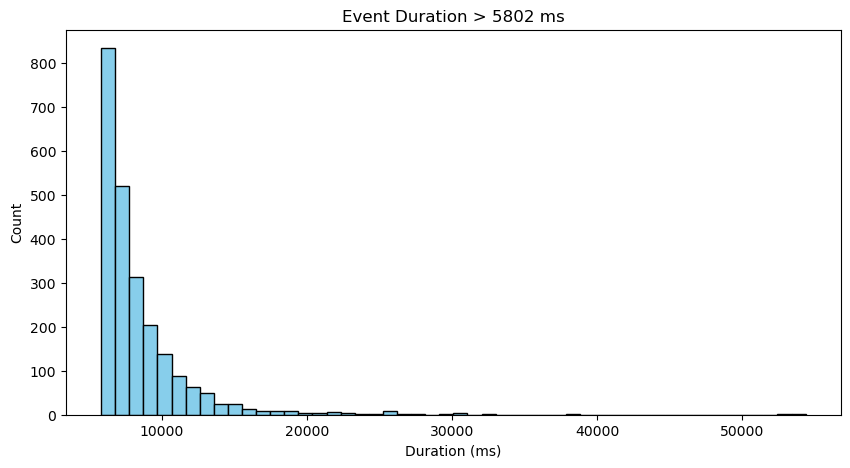

In [5]:
### Anomalies of Concern 
## duration_ms outliers
print((events['duration_ms'] > 2600).mean() * 100) # IQR * 1.5 + Q3
print((events['duration_ms'] > 10000).mean() * 100)
print((events['duration_ms'] > 17500).mean() * 100)
print(events['duration_ms'].quantile([0.95, 0.99, 0.995]))

# Filter for tail values
duration_tail = events[events['duration_ms'] > 5802.00]['duration_ms']

# Histogram of tail values
plt.figure(figsize=(10, 5))
plt.hist(duration_tail, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Duration (ms)')
plt.ylabel('Count')
plt.title('Event Duration > 5802 ms')
plt.show()

# CHANGE: Cap duration_ms at 17500 (0.25% of the data) and flag
events['duration_extreme'] = (events['duration_ms'] >= 17500).astype(int)
events['duration_ms_capped'] = events['duration_ms'].clip(upper=17500)

8.896039329319034
0.02560502541298772
0.950     632.0
0.990    1079.0
0.995    1389.0
Name: latency_ms, dtype: float64


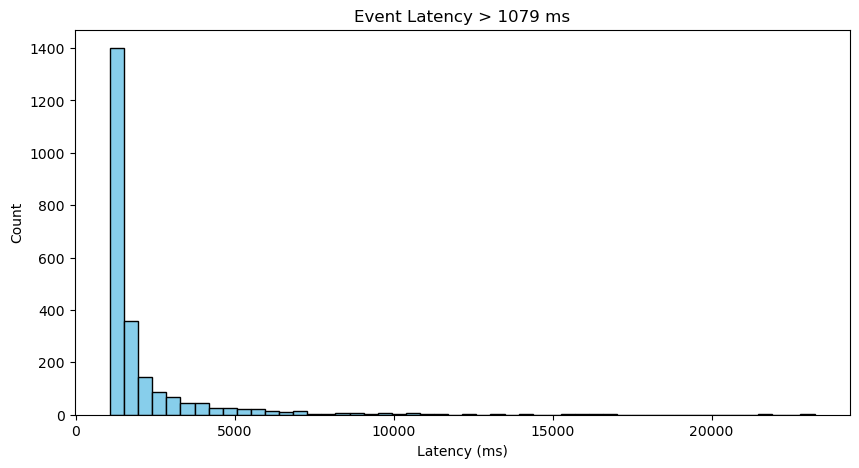

In [6]:
## latency_ms outliers
print((events['latency_ms'] > 508).mean() * 100) # IQR * 1.5 + Q3
print((events['latency_ms'] > 7500).mean() * 100) 
print(events['latency_ms'].quantile([0.95, 0.99, 0.995]))

# Filter for tail values
latency_tail = events[events['latency_ms'] > 1079]['latency_ms']

# Histogram of tail values
plt.figure(figsize=(10, 5))
plt.hist(latency_tail, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Latency (ms)')
plt.ylabel('Count')
plt.title('Event Latency > 1079 ms')
plt.show()

# CHANGE: Cap location_ms at 7500 (0.25% of the data) and flag
events['latency_extreme']  = (events['latency_ms']  >= 7500).astype(int)
events['latency_ms_capped'] = events['latency_ms'].clip(upper=7500)

In [7]:
### Define 30d and 90d target windows
## 30d window
sessions_30d = sessions.merge(users[['user_id','signup_date']], on='user_id')
sessions_30d = sessions_30d[sessions_30d['session_start'] <= sessions_30d['signup_date'] + pd.Timedelta(days=30)]

events_30d = events.merge(users[['user_id','signup_date']], on='user_id')
events_30d = events_30d[events_30d['ts'] <= events_30d['signup_date'] + pd.Timedelta(days=30)]

billing = billing.merge(users[['user_id', 'signup_date']], on='user_id')

# first billing month = the first month start after signup
billing['first_billing_month'] = billing['signup_date'] + pd.offsets.MonthBegin(1)

# filter billing within 30d (first billing row)
billing_30d = billing[billing['month'] == billing['first_billing_month']]

## 90d window
sessions_90d = sessions.merge(users[['user_id','signup_date']], on='user_id')
sessions_90d = sessions_90d[sessions_90d['session_start'] <= sessions_90d['signup_date'] + pd.Timedelta(days=90)]

events_90d = events.merge(users[['user_id','signup_date']], on='user_id')
events_90d = events_90d[events_90d['ts'] <= events_90d['signup_date'] + pd.Timedelta(days=90)]

billing_90d = billing[
    (billing['month'] >= billing['first_billing_month']) &
    (billing['month'] < billing['first_billing_month'] + pd.DateOffset(months=3))
]

In [8]:
## Gini function for feature usage 
def gini(array):
    array = np.array(array, dtype=np.float64)
    if array.sum() == 0:
        return 0.0
    array = np.sort(array)
    n = len(array)
    cumvals = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n

In [9]:
### CHANGE: Aggregate function for 30d and 90d windows
def aggregate_user_features_full(sessions, events, billing, window_label):
    ## Session aggregates
    session_agg = sessions.groupby('user_id').agg(
        total_sessions=('session_id', 'count'),                          # Total number of sessions in the window
        avg_session_length=('session_length_sec', 'mean'),               # Avg duration of sessions
        median_session_length=('session_length_sec', 'median'),          # Median duration (robust to skew)
        active_days=('session_start', lambda x: x.dt.date.nunique()),    # Unique days with at least 1 session
        num_unique_devices=('device', 'nunique'),                        # Number of distinct devices used
        num_unique_os=('os', 'nunique'),                                 # Number of distinct OS used
    ).reset_index()
    
    # Optional: Engagement shape
    session_agg['sessions_per_active_day'] = session_agg['total_sessions'] / session_agg['active_days']
    
    # Optional: Activation timing
    session_agg['days_since_signup_to_first_session'] = sessions.groupby('user_id')['session_start'].min() - users.set_index('user_id')['signup_date']
    session_agg['days_since_signup_to_first_session'] = session_agg['days_since_signup_to_first_session'].dt.days
    
    session_agg['avg_session_start_hour'] = sessions.groupby('user_id')['session_start'].apply(lambda x: x.dt.hour.mean()).values
    session_agg['weekend_usage_ratio'] = sessions.groupby('user_id')['session_start'].apply(
        lambda x: (x.dt.weekday >=5).sum() / len(x)
    ).values
    
    ## Event aggregates
    event_agg = events.groupby('user_id').agg(
        total_events=('event_id', 'count'),                               # Total events
        event_success_rate=('success', 'mean'),                           # Proportion of successful events
        avg_latency_ms_capped=('latency_ms_capped', 'mean'),              # Average capped latency
        avg_duration_ms_capped=('duration_ms_capped', 'mean'),            # Average capped duration
        unique_features_used=('feature_name', 'nunique'),                 # Number of distinct features used
        duration_extreme=('duration_extreme', 'sum'),                     # Count of extreme duration events
        latency_extreme=('latency_extreme', 'sum'),                       # Count of extreme latency events
    ).reset_index()
    
    # Optional: Events per session
    event_agg = event_agg.merge(session_agg[['user_id','total_sessions']], on='user_id', how='left')
    event_agg['events_per_session'] = event_agg['total_events'] / event_agg['total_sessions']
    
    # Optional: Concentration vs breadth
    # Gini coefficient for feature usage (how skewed their feature use is)
    feature_counts = events.groupby(['user_id','feature_name']).size().unstack(fill_value=0)
    event_agg['gini_feature_usage'] = feature_counts.apply(gini, axis=1).reindex(event_agg['user_id']).values
    event_agg['top_feature_share'] = feature_counts.max(axis=1).reindex(event_agg['user_id']).values / event_agg['total_events']
    
    ## Billing aggregates
    billing_agg = billing.groupby('user_id').agg(
        total_mrr=('mrr', 'sum'),                                         # Total revenue in the window
        active_seats=('active_seats', 'sum'),                              # Total active seats
        any_invoices_overdue=('invoices_overdue', 'max'),                  # Flag: any invoice overdue in window
        support_ticket_count=('support_ticket_count', 'sum'),              # Count of support tickets
        discount_applied_ratio=('discount_applied', 'mean')                # Fraction of invoices with discount applied
    ).reset_index()

    # Optional: Seats per active day
    # Make sure to handle divide-by-zero if user has 0 active_days
    billing_agg = billing_agg.merge(session_agg[['user_id','active_days']], on='user_id', how='left')
    billing_agg['seats_per_active_day'] = billing_agg['active_seats'] / billing_agg['active_days'].replace(0, np.nan)
    
    # Optional:
    # Growth_in_seats, delta_mrr_30→90d could be computed here later
    # Retention proxies: did they return after day 7 / day 14 (requires session-level computation)
    # growth_in_seats_within_first90d, delta_mrr_30_90d, support_tickets_per_active_seat, etc.
    
    ## MERGE ALL TO USER-LEVEL TABLE 
    user_features = users[['user_id','signup_date','plan_tier','company_size','region',
                           'industry','acquisition_channel','is_enterprise',
                           'churned_30d','churned_90d','downgraded','expansion_event']].copy()
    
    user_features = user_features.merge(session_agg, on='user_id', how='left')
    user_features = user_features.merge(event_agg, on='user_id', how='left')
    user_features = user_features.merge(billing_agg, on='user_id', how='left')
    
    user_features['window'] = window_label
    
    return user_features

## CREATE 30d AND 90d DATASETS
user_features_30d = aggregate_user_features_full(sessions_30d, events_30d, billing_30d, '30d')
user_features_90d = aggregate_user_features_full(sessions_90d, events_90d, billing_90d, '90d')

# Save intermediate artifacts
user_features_30d.to_csv('user_first30d.csv', index=False)
user_features_90d.to_csv('user_first90d.csv', index=False)

In [10]:
# Fix _x/_y duplication
def clean_total_sessions(df):
    if 'total_sessions_x' in df.columns:
        df.rename(columns={'total_sessions_x':'total_sessions'}, inplace=True)
    if 'total_sessions_y' in df.columns:
        df.drop(columns=['total_sessions_y'], inplace=True)
    return df

user_features_30d = clean_total_sessions(user_features_30d)
user_features_90d = clean_total_sessions(user_features_90d)

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


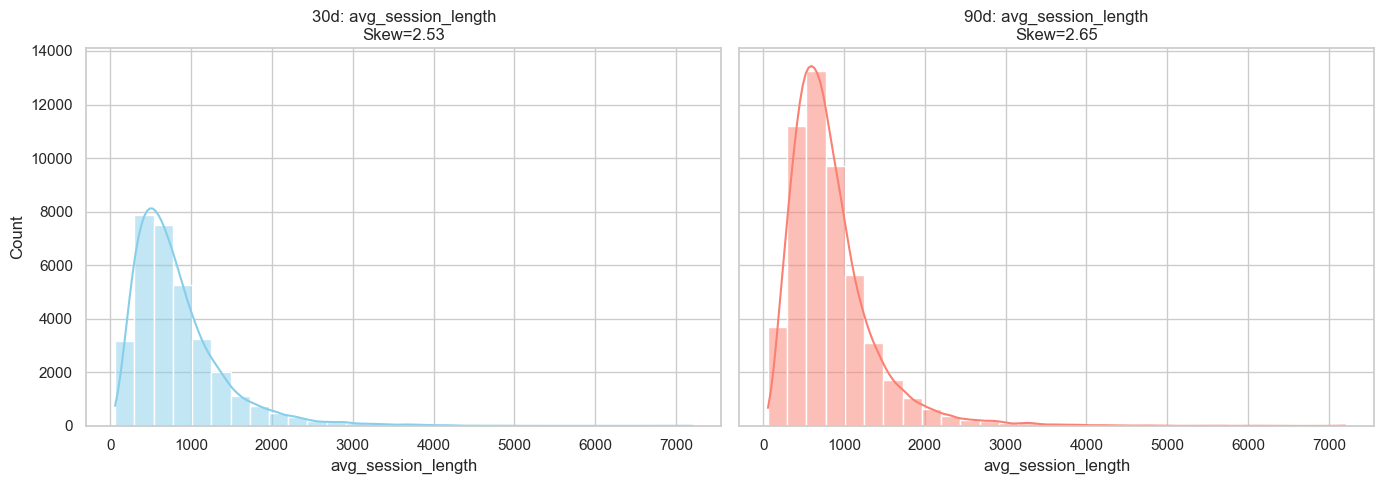

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


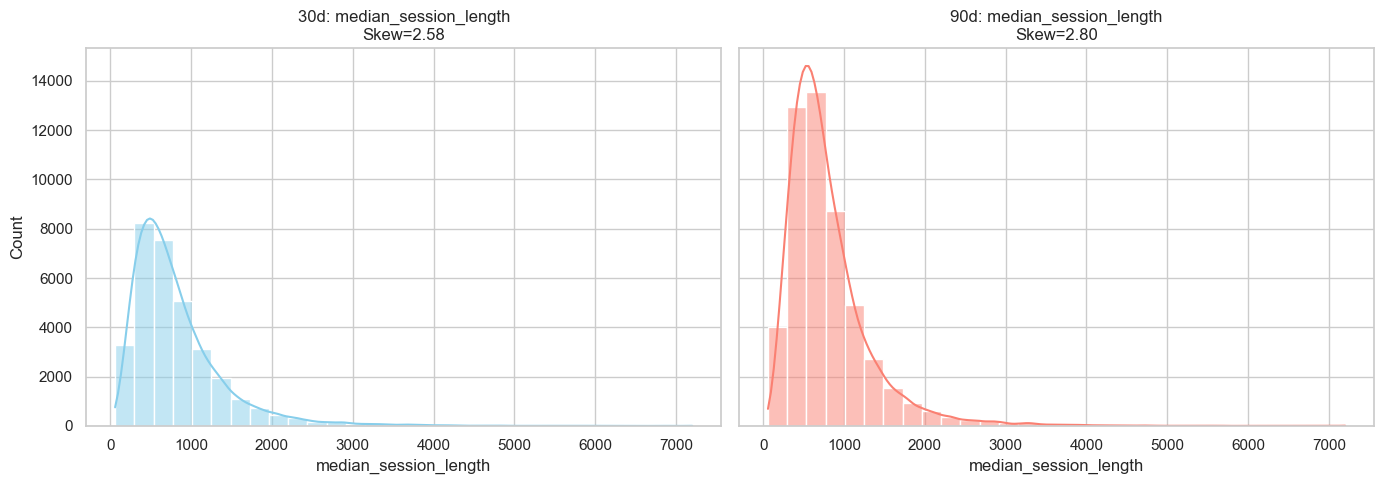

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


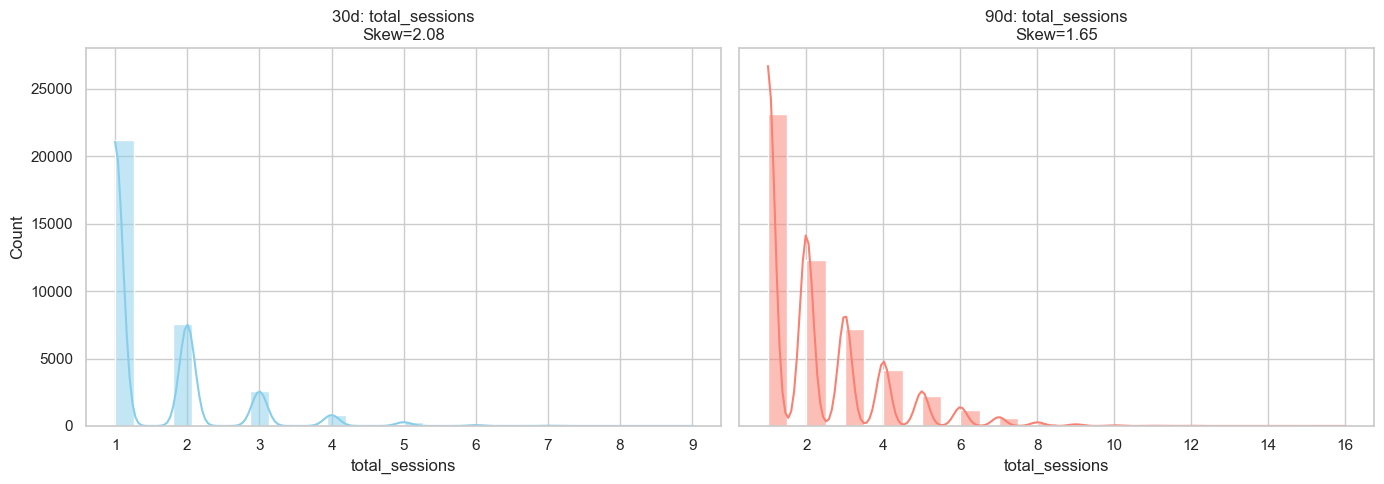

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


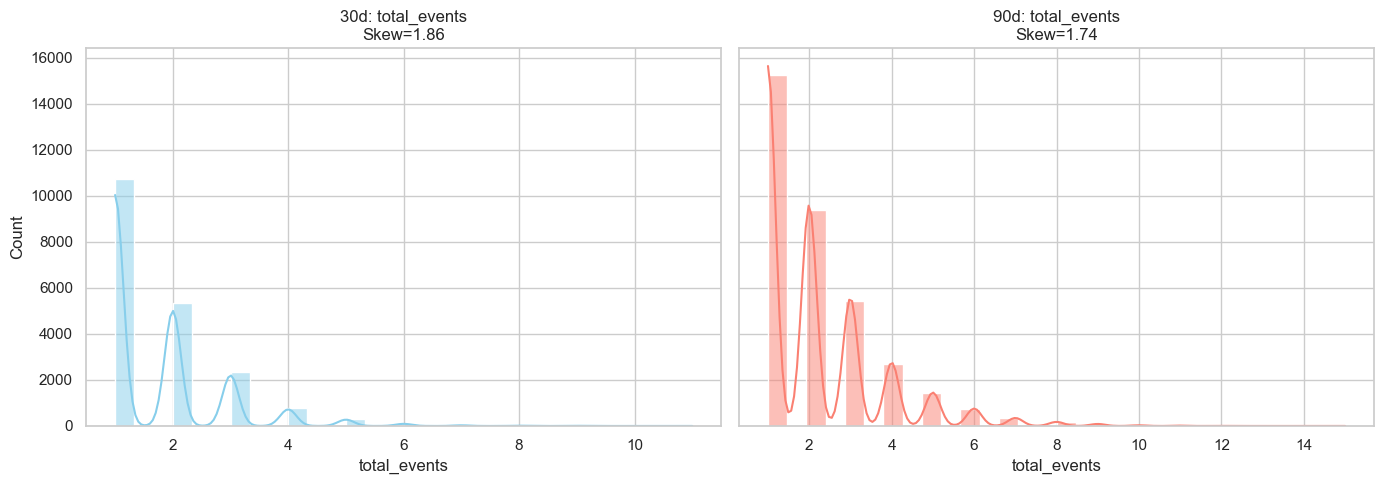

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


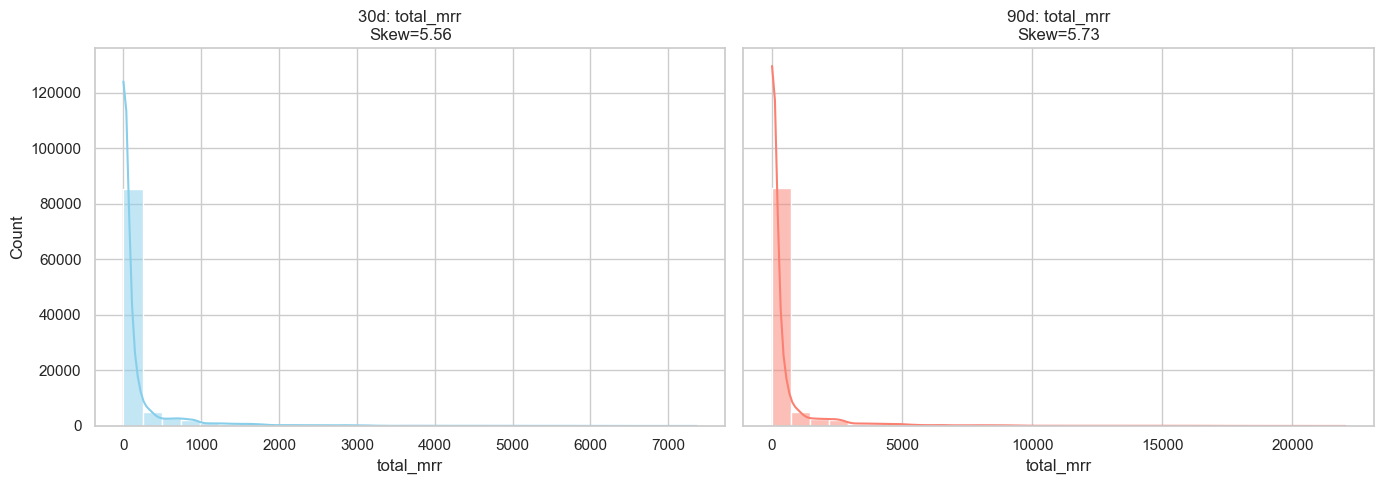

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


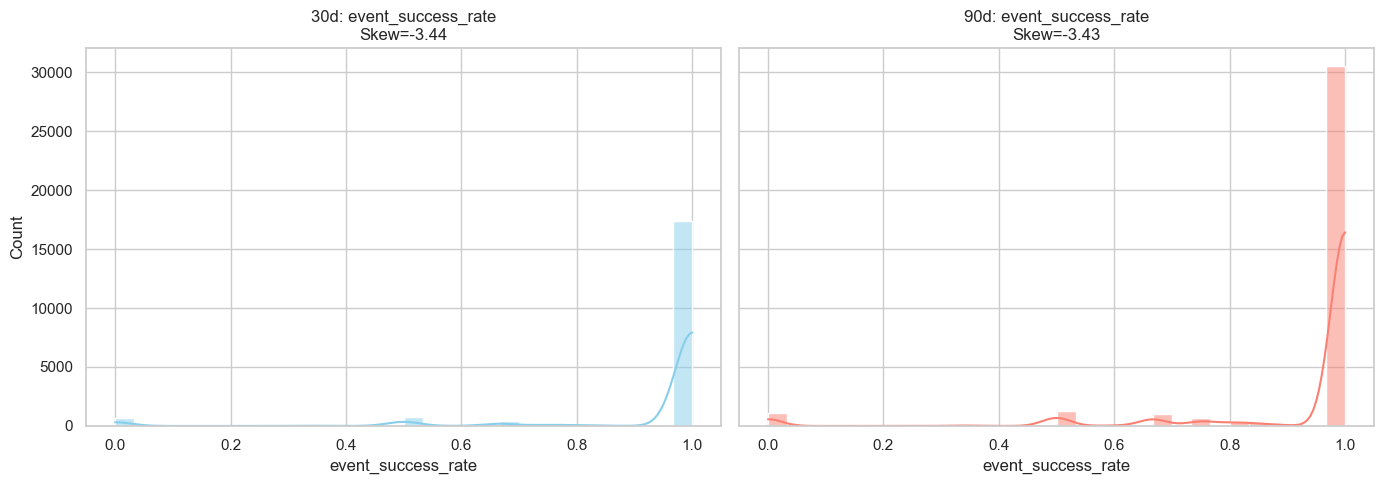

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


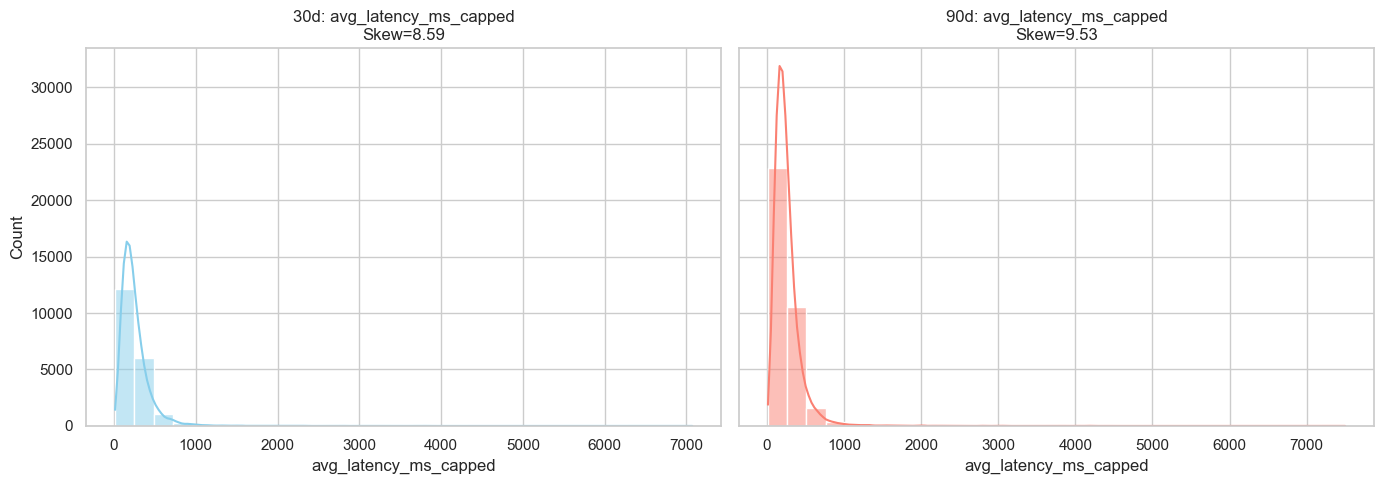

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


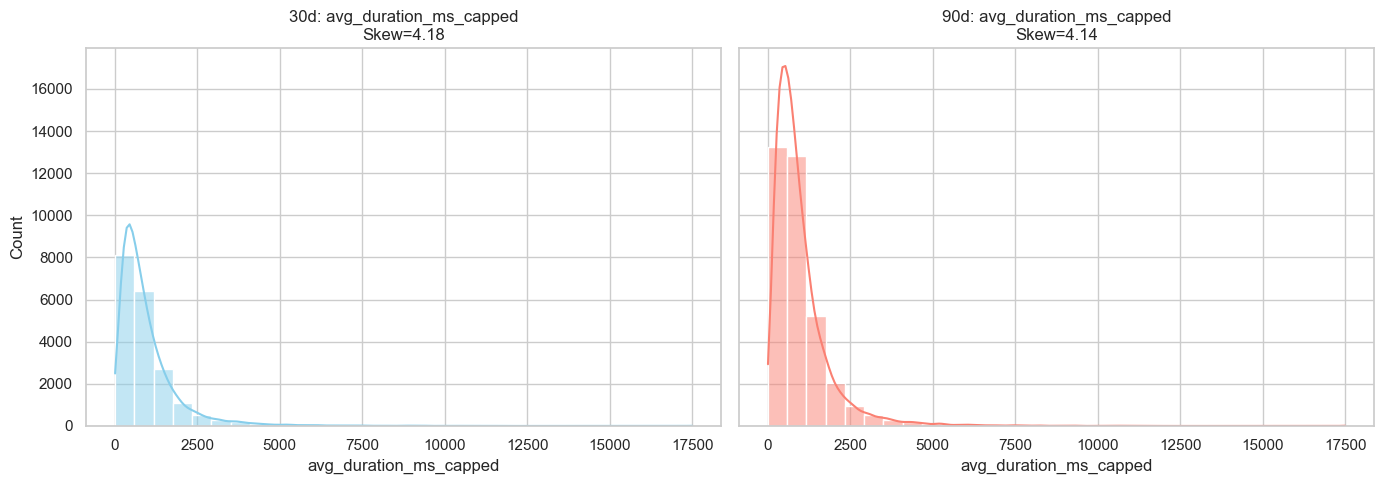

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


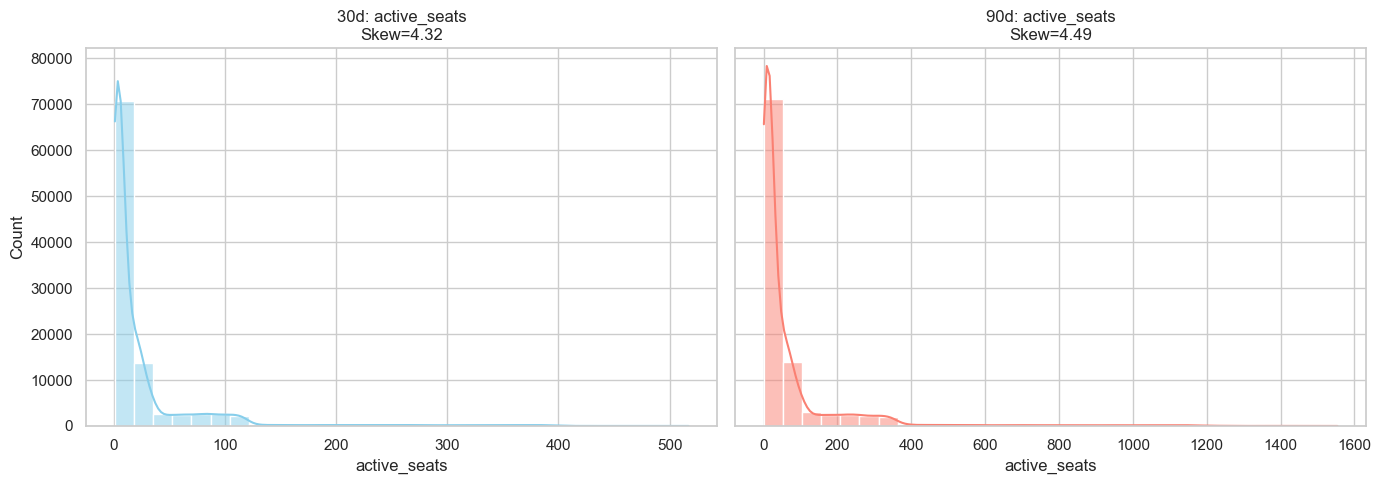

In [11]:
### Phase One - Baseline Features EDA
## Numeric Distributions: 30d vs 90d
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14,6)

# Copy datasets
df_30d = user_features_30d.copy()
df_90d = user_features_90d.copy()

# Numeric features to inspect
numeric_features_eda = [
    'avg_session_length', 'median_session_length', 'total_sessions',
    'total_events', 'total_mrr', 'event_success_rate',
    'avg_latency_ms_capped', 'avg_duration_ms_capped', 'active_seats'
]

# Filter features that exist in both datasets
numeric_features_eda = [
    col for col in numeric_features_eda 
    if col in df_30d.columns and col in df_90d.columns
]

# CHANGE: Log-transform selected skewed features (add log_ columns)
log_transform_features = [
    'total_mrr', 
    'avg_latency_ms_capped', 
    'avg_duration_ms_capped', 
    'active_seats'
]

for df in [df_30d, df_90d]:
    for col in log_transform_features:
        if col in df.columns:
            df[f'log_{col}'] = np.log1p(df[col])  # safe log

# Plot raw 30d vs 90d side by side for each numeric feature
for col in numeric_features_eda:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    sns.histplot(df_30d[col], kde=True, bins=30, color='skyblue', line_kws={'color':'blue'}, ax=axes[0])
    axes[0].set_title(f'30d: {col}\nSkew={df_30d[col].skew():.2f}', fontsize=12)
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Count')
    
    sns.histplot(df_90d[col], kde=True, bins=30, color='salmon', line_kws={'color':'red'}, ax=axes[1])
    axes[1].set_title(f'90d: {col}\nSkew={df_90d[col].skew():.2f}', fontsize=12)
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


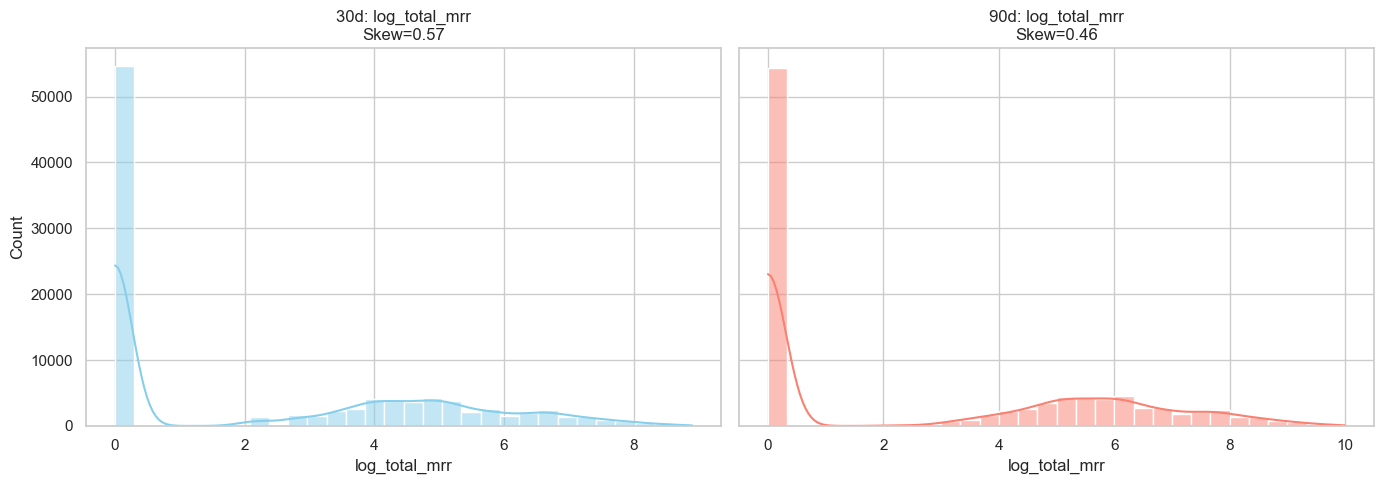

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


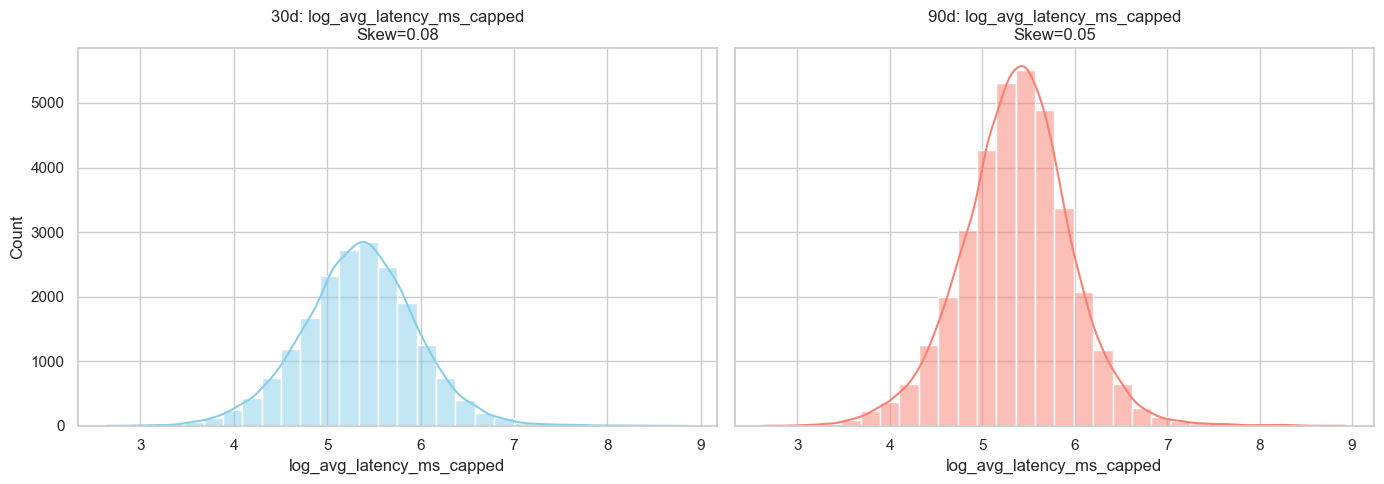

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


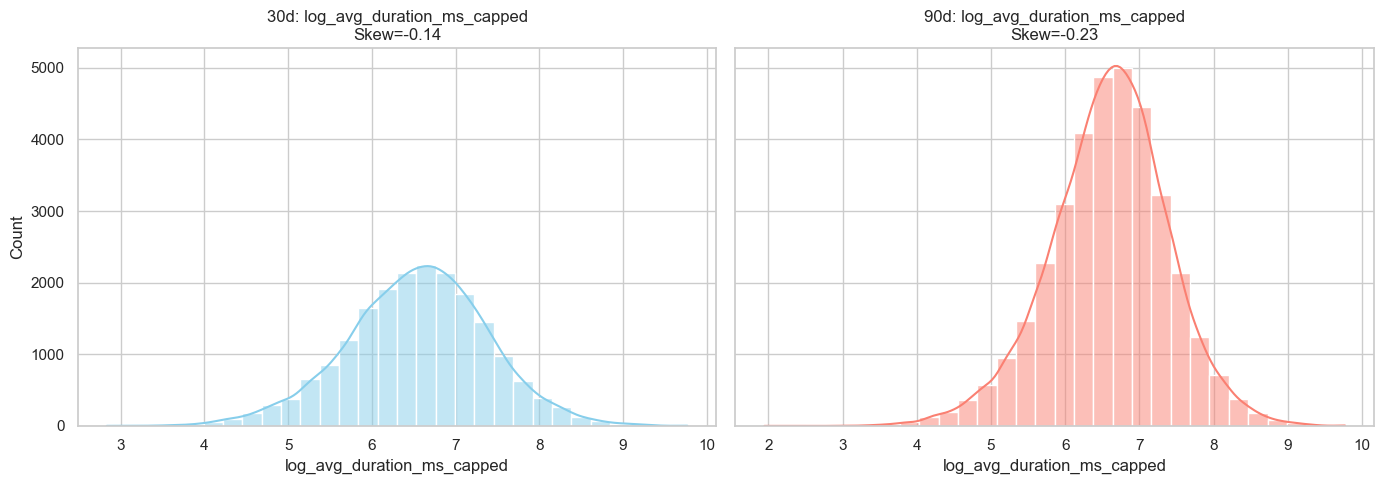

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


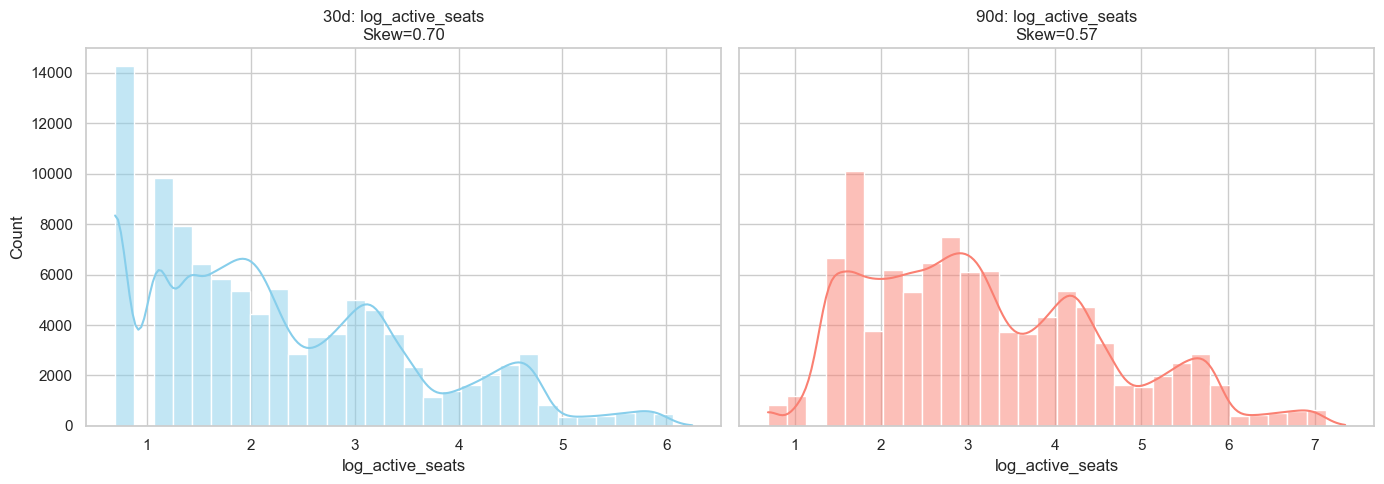

In [12]:
## Log-transformed distributions for the skewed ones
for col in log_transform_features:
    if col in df_30d.columns and col in df_90d.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
        
        sns.histplot(df_30d[f'log_{col}'], kde=True, bins=30, color='skyblue', line_kws={'color':'blue'}, ax=axes[0])
        axes[0].set_title(f'30d: log_{col}\nSkew={df_30d[f"log_{col}"].skew():.2f}', fontsize=12)
        axes[0].set_xlabel(f'log_{col}')
        axes[0].set_ylabel('Count')

        sns.histplot(df_90d[f'log_{col}'], kde=True, bins=30, color='salmon', line_kws={'color':'red'}, ax=axes[1])
        axes[1].set_title(f'90d: log_{col}\nSkew={df_90d[f"log_{col}"].skew():.2f}', fontsize=12)
        axes[1].set_xlabel(f'log_{col}')
        axes[1].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

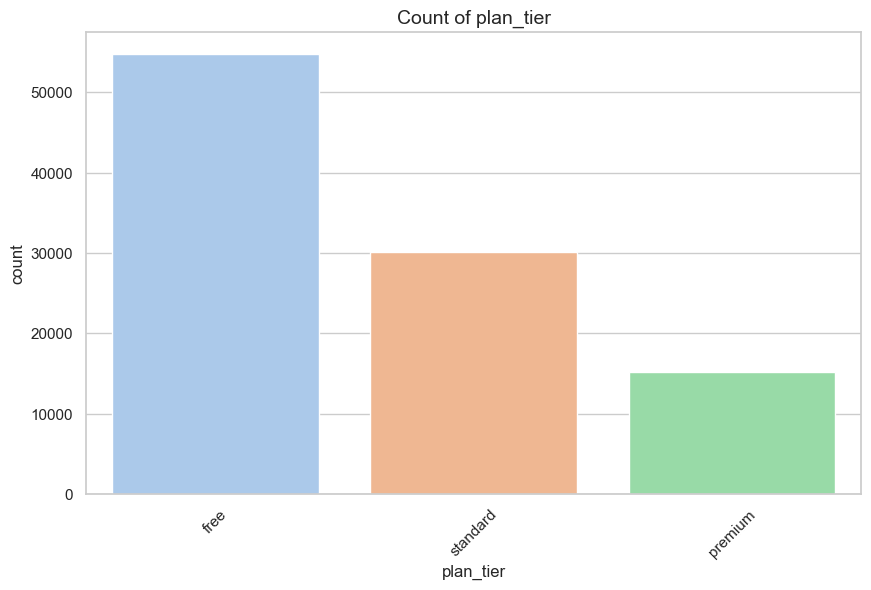

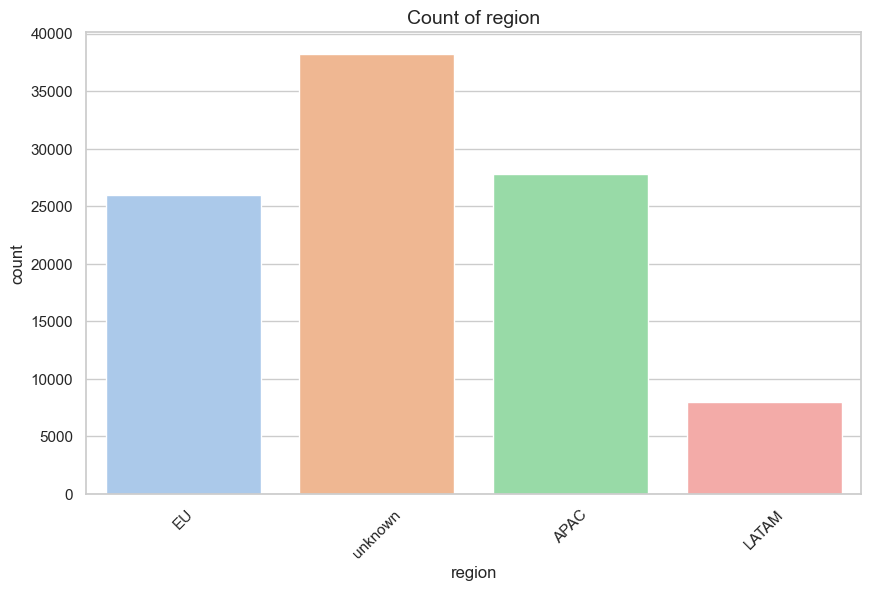

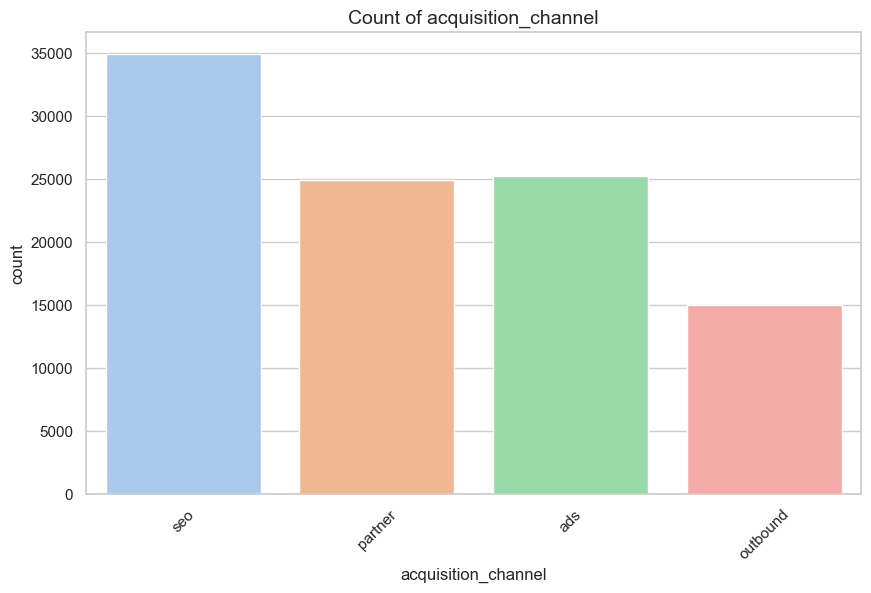

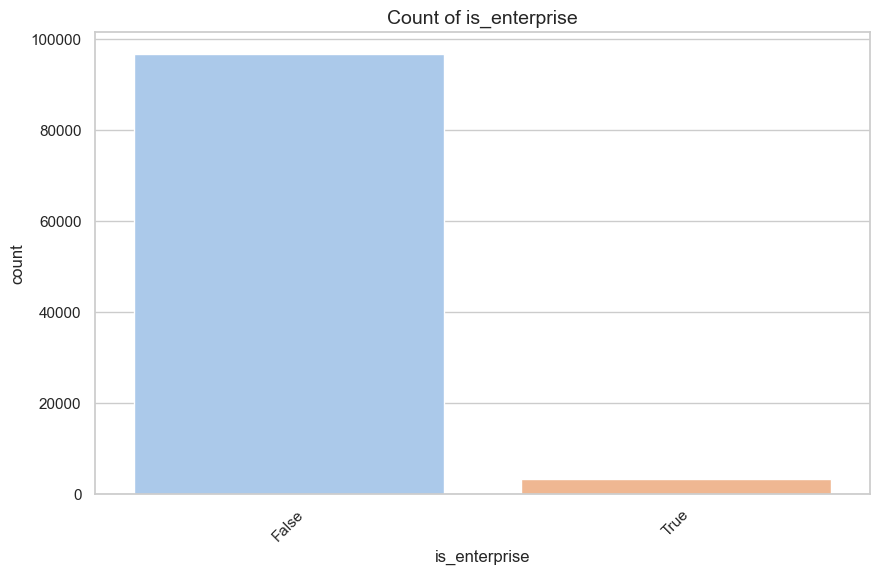

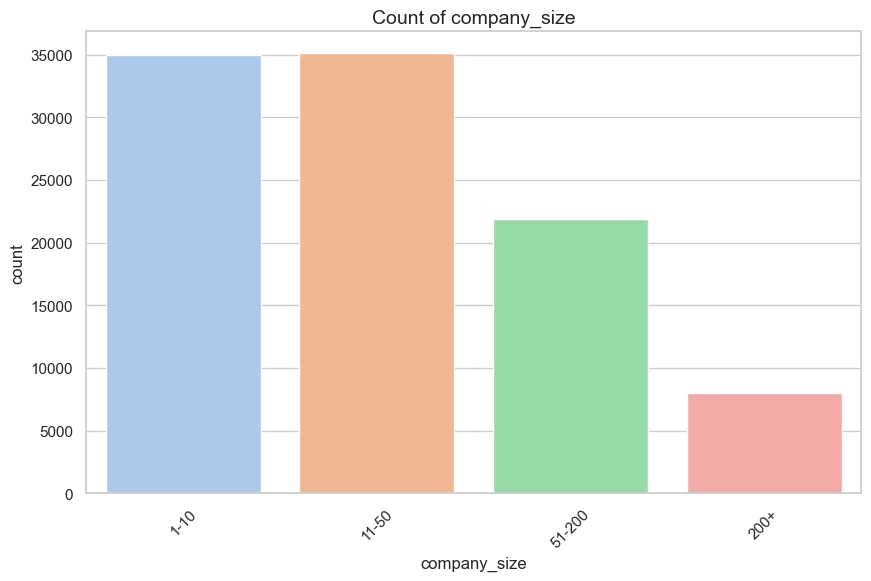


Crosstab: plan_tier vs churned_30d


churned_30d,0,1
plan_tier,,
free,0.834535,0.165465
premium,0.941215,0.058785
standard,0.900013,0.099987



Crosstab: plan_tier vs churned_90d


churned_90d,0,1
plan_tier,,
free,0.681064,0.318936
premium,0.936333,0.063667
standard,0.848457,0.151543



Crosstab: plan_tier vs downgraded


downgraded,0,1
plan_tier,,
free,0.999781,0.000219
premium,0.955730,0.044270
standard,0.955428,0.044572



Crosstab: plan_tier vs expansion_event


expansion_event,0,1
plan_tier,,
free,0.234725,0.765275
premium,0.391436,0.608564
standard,0.395822,0.604178



Crosstab: region vs churned_30d


churned_30d,0,1
region,,
APAC,0.873103,0.126897
EU,0.866911,0.133089
LATAM,0.870097,0.129903
unknown,0.870840,0.129160



Crosstab: region vs churned_90d


churned_90d,0,1
region,,
APAC,0.765300,0.234700
EU,0.767797,0.232203
LATAM,0.766675,0.233325
unknown,0.775821,0.224179



Crosstab: region vs downgraded


downgraded,0,1
region,,
APAC,0.979755,0.020245
EU,0.979931,0.020069
LATAM,0.978891,0.021109
unknown,0.979856,0.020144



Crosstab: region vs expansion_event


expansion_event,0,1
region,,
APAC,0.305502,0.694498
EU,0.307935,0.692065
LATAM,0.310517,0.689483
unknown,0.306483,0.693517



Crosstab: acquisition_channel vs churned_30d


churned_30d,0,1
acquisition_channel,,
ads,0.862568,0.137432
outbound,0.866306,0.133694
partner,0.875231,0.124769
seo,0.874334,0.125666



Crosstab: acquisition_channel vs churned_90d


churned_90d,0,1
acquisition_channel,,
ads,0.763076,0.236924
outbound,0.762048,0.237952
partner,0.776564,0.223436
seo,0.773956,0.226044



Crosstab: acquisition_channel vs downgraded


downgraded,0,1
acquisition_channel,,
ads,0.979721,0.020279
outbound,0.980710,0.019290
partner,0.980243,0.019757
seo,0.979065,0.020935



Crosstab: acquisition_channel vs expansion_event


expansion_event,0,1
acquisition_channel,,
ads,0.304548,0.695452
outbound,0.311240,0.688760
partner,0.305116,0.694884
seo,0.308036,0.691964



Crosstab: is_enterprise vs churned_30d


churned_30d,0,1
is_enterprise,,
False,0.867946,0.132054
True,0.944167,0.055833



Crosstab: is_enterprise vs churned_90d


churned_90d,0,1
is_enterprise,,
False,0.764469,0.235531
True,0.939488,0.060512



Crosstab: is_enterprise vs downgraded


downgraded,0,1
is_enterprise,,
False,0.980329,0.019671
True,0.962882,0.037118



Crosstab: is_enterprise vs expansion_event


expansion_event,0,1
is_enterprise,,
False,0.289687,0.710313
True,0.826887,0.173113



Crosstab: company_size vs churned_30d


churned_30d,0,1
company_size,,
1-10,0.859269,0.140731
11-50,0.869291,0.130709
200+,0.890481,0.109519
51-200,0.882519,0.117481



Crosstab: company_size vs churned_90d


churned_90d,0,1
company_size,,
1-10,0.744148,0.255852
11-50,0.767898,0.232102
200+,0.824196,0.175804
51-200,0.795093,0.204907



Crosstab: company_size vs downgraded


downgraded,0,1
company_size,,
1-10,0.979797,0.020203
11-50,0.979146,0.020854
200+,0.979566,0.020434
51-200,0.980800,0.019200



Crosstab: company_size vs expansion_event


expansion_event,0,1
company_size,,
1-10,0.089653,0.910347
11-50,0.196889,0.803111
200+,0.855968,0.144032
51-200,0.628312,0.371688


In [13]:
### Categorical Summaries 
df_30d = user_features_30d.copy()

categorical_features = ['plan_tier', 'region', 'acquisition_channel', 'is_enterprise', 'company_size']
targets = ['churned_30d', 'churned_90d', 'downgraded', 'expansion_event']

company_size_order = ['1-10', '11-50', '51-200', '200+']

# Countplots
for col in categorical_features:
    if col not in df_30d.columns:
        continue
    
    plt.figure(figsize=(10,6))
    
    if col == 'company_size':
        sns.countplot(data=df_30d, x=col, palette='pastel', order=company_size_order)
    else:
        sns.countplot(data=df_30d, x=col, palette='pastel')  # natural order
    
    plt.title(f'Count of {col}', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

# Crosstabs
for col in categorical_features:
    if col not in df_30d.columns:
        continue
    
    for target in targets:
        if target not in df_30d.columns:
            continue
        
        print(f'\nCrosstab: {col} vs {target}')
        ctab = pd.crosstab(df_30d[col], df_30d[target], normalize='index')
        display(ctab)


C:\Users\Arum Titan\AppData\Local\Temp\ipykernel_8356\1526525276.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_30d = df_30d_plot.groupby('company_size')['churned_30d'].mean().reset_index()
C:\Users\Arum Titan\AppData\Local\Temp\ipykernel_8356\1526525276.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_90d = df_90d_plot.groupby('company_size')['churned_90d'].mean().reset_index()


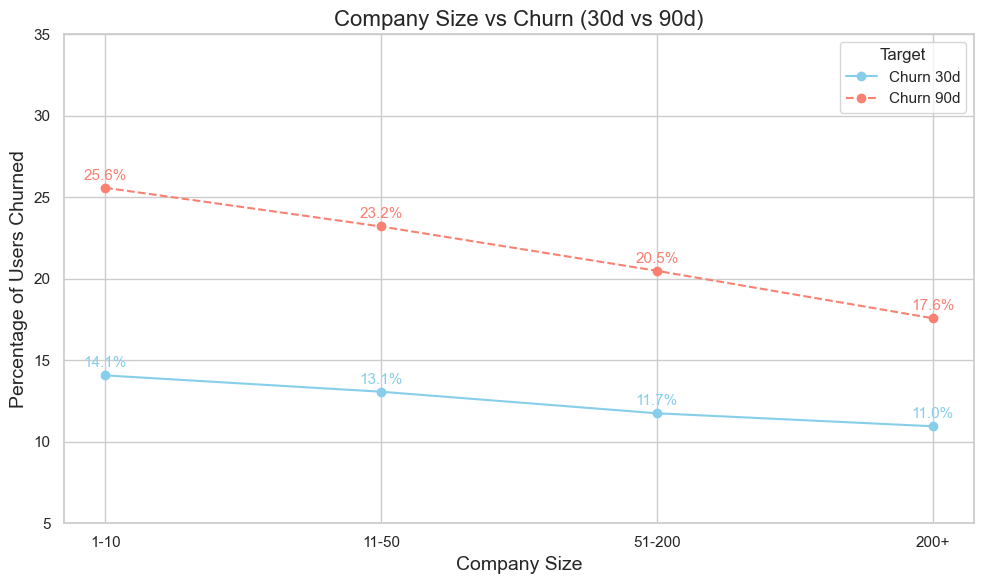

In [14]:
## INSIGHT ONE: Company Size vs Churn
# Datasets
df_30d_plot = user_features_30d.copy()
df_90d_plot = user_features_90d.copy()

# Ensure company_size has logical order
company_order = ['1-10', '11-50', '51-200', '200+']
for df in [df_30d_plot, df_90d_plot]:
    df['company_size'] = pd.Categorical(df['company_size'], categories=company_order, ordered=True)

# Calculate proportions for churn only and convert to percentage
prop_30d = df_30d_plot.groupby('company_size')['churned_30d'].mean().reset_index()
prop_90d = df_90d_plot.groupby('company_size')['churned_90d'].mean().reset_index()
prop_30d['churned_30d'] *= 100
prop_90d['churned_90d'] *= 100

# Plot
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")

plt.plot(prop_30d['company_size'], prop_30d['churned_30d'], marker='o', linestyle='-', color='skyblue', label='Churn 30d')
plt.plot(prop_90d['company_size'], prop_90d['churned_90d'], marker='o', linestyle='--', color='salmon', label='Churn 90d')

# Add data labels
for i in range(len(prop_30d)):
    plt.text(i, prop_30d['churned_30d'][i]+0.5, f"{prop_30d['churned_30d'][i]:.1f}%", ha='center', color='skyblue', fontsize=11)
    plt.text(i, prop_90d['churned_90d'][i]+0.5, f"{prop_90d['churned_90d'][i]:.1f}%", ha='center', color='salmon', fontsize=11)

plt.title('Company Size vs Churn (30d vs 90d)', fontsize=16)
plt.xlabel('Company Size', fontsize=14)
plt.ylabel('Percentage of Users Churned', fontsize=14)

# Zoom y-axis to highlight gradient differences
plt.ylim(5, 35)

plt.legend(title='Target')
plt.tight_layout()
plt.show()


C:\Users\Arum Titan\AppData\Local\Temp\ipykernel_8356\153332739.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_30d = df_30d_plot.groupby('plan_tier')['churned_30d'].mean().reset_index()
C:\Users\Arum Titan\AppData\Local\Temp\ipykernel_8356\153332739.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_90d = df_90d_plot.groupby('plan_tier')['churned_90d'].mean().reset_index()


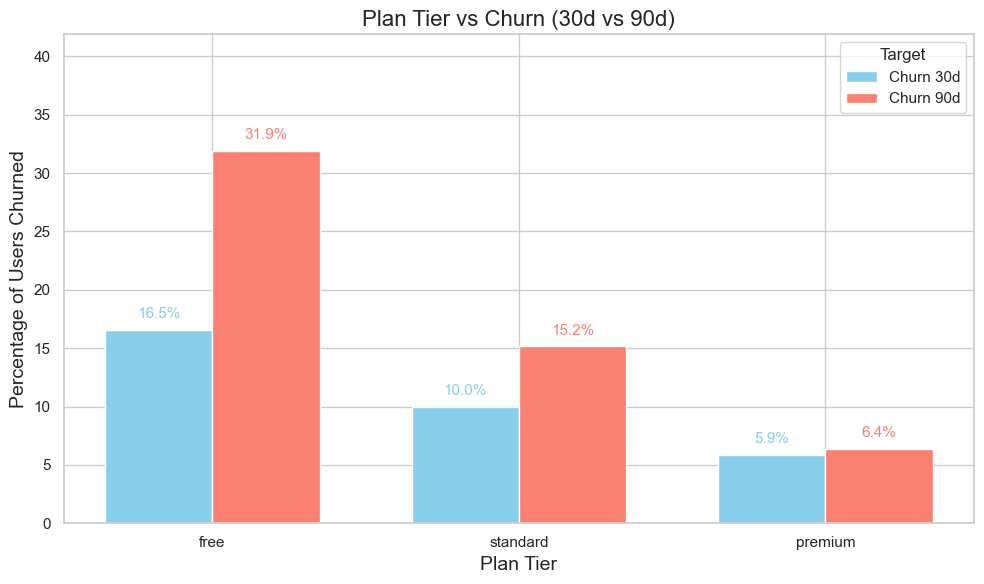

In [15]:
## INSIGHT TWO: Plan Tier vs Churn
# Datasets
df_30d_plot = user_features_30d.copy()
df_90d_plot = user_features_90d.copy()

# Plan tiers in desired order
plan_order = ['free', 'standard', 'premium']
for df in [df_30d_plot, df_90d_plot]:
    df['plan_tier'] = pd.Categorical(df['plan_tier'], categories=plan_order, ordered=True)

# Calculate churn proportions
churn_30d = df_30d_plot.groupby('plan_tier')['churned_30d'].mean().reset_index()
churn_90d = df_90d_plot.groupby('plan_tier')['churned_90d'].mean().reset_index()

# Merge into one dataframe for plotting
churn_plot = pd.merge(churn_30d, churn_90d, on='plan_tier')
churn_plot.rename(columns={'churned_30d':'Churn 30d', 'churned_90d':'Churn 90d'}, inplace=True)

# Plot
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")

bar_width = 0.35
x = np.arange(len(plan_order))

plt.bar(x - bar_width/2, churn_plot['Churn 30d']*100, width=bar_width, color='skyblue', label='Churn 30d')
plt.bar(x + bar_width/2, churn_plot['Churn 90d']*100, width=bar_width, color='salmon', label='Churn 90d')

# Add data labels
for i in range(len(plan_order)):
    plt.text(x[i] - bar_width/2, churn_plot['Churn 30d'][i]*100 + 1, f"{churn_plot['Churn 30d'][i]*100:.1f}%", ha='center', color='skyblue', fontsize=11)
    plt.text(x[i] + bar_width/2, churn_plot['Churn 90d'][i]*100 + 1, f"{churn_plot['Churn 90d'][i]*100:.1f}%", ha='center', color='salmon', fontsize=11)

plt.xticks(x, plan_order)
plt.xlabel('Plan Tier', fontsize=14)
plt.ylabel('Percentage of Users Churned', fontsize=14)
plt.title('Plan Tier vs Churn (30d vs 90d)', fontsize=16)
plt.ylim(0, max(churn_plot[['Churn 30d','Churn 90d']].max())*100 + 10)
plt.legend(title='Target')
plt.tight_layout()
plt.show()


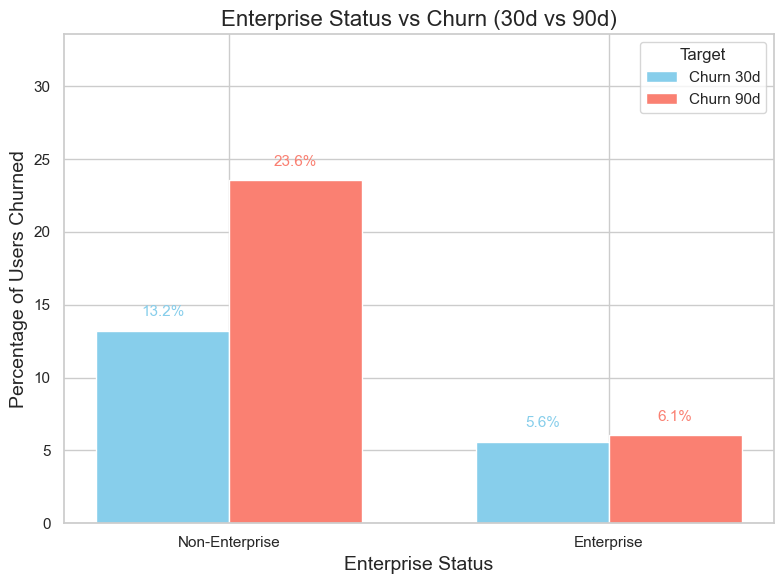

In [16]:
## INSIGHT THREE: is_enterprise vs Churn

# Datasets
df_30d_plot = user_features_30d.copy()
df_90d_plot = user_features_90d.copy()

# Ensure 'is_enterprise' is boolean / categorical
for df in [df_30d_plot, df_90d_plot]:
    df['is_enterprise'] = df['is_enterprise'].astype(bool)
enterprise_order = [False, True]

# Calculate churn proportions
churn_30d = df_30d_plot.groupby('is_enterprise')['churned_30d'].mean().reset_index()
churn_90d = df_90d_plot.groupby('is_enterprise')['churned_90d'].mean().reset_index()

# Merge into one dataframe for plotting
churn_plot = pd.merge(churn_30d, churn_90d, on='is_enterprise')
churn_plot.rename(columns={'churned_30d':'Churn 30d', 'churned_90d':'Churn 90d'}, inplace=True)

# Plot
plt.figure(figsize=(8,6))
sns.set(style="whitegrid")

bar_width = 0.35
x = np.arange(len(enterprise_order))

plt.bar(x - bar_width/2, churn_plot['Churn 30d']*100, width=bar_width, color='skyblue', label='Churn 30d')
plt.bar(x + bar_width/2, churn_plot['Churn 90d']*100, width=bar_width, color='salmon', label='Churn 90d')

# Add data labels
for i in range(len(enterprise_order)):
    plt.text(x[i] - bar_width/2, churn_plot['Churn 30d'][i]*100 + 1, f"{churn_plot['Churn 30d'][i]*100:.1f}%", ha='center', color='skyblue', fontsize=11)
    plt.text(x[i] + bar_width/2, churn_plot['Churn 90d'][i]*100 + 1, f"{churn_plot['Churn 90d'][i]*100:.1f}%", ha='center', color='salmon', fontsize=11)

plt.xticks(x, ['Non-Enterprise', 'Enterprise'])
plt.xlabel('Enterprise Status', fontsize=14)
plt.ylabel('Percentage of Users Churned', fontsize=14)
plt.title('Enterprise Status vs Churn (30d vs 90d)', fontsize=16)
plt.ylim(0, max(churn_plot[['Churn 30d','Churn 90d']].max())*100 + 10)
plt.legend(title='Target')
plt.tight_layout()
plt.show()


C:\Users\Arum Titan\AppData\Local\Temp\ipykernel_8356\2753954802.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  company_props = df_exp.groupby('company_size')['expansion_event'].mean() * 100


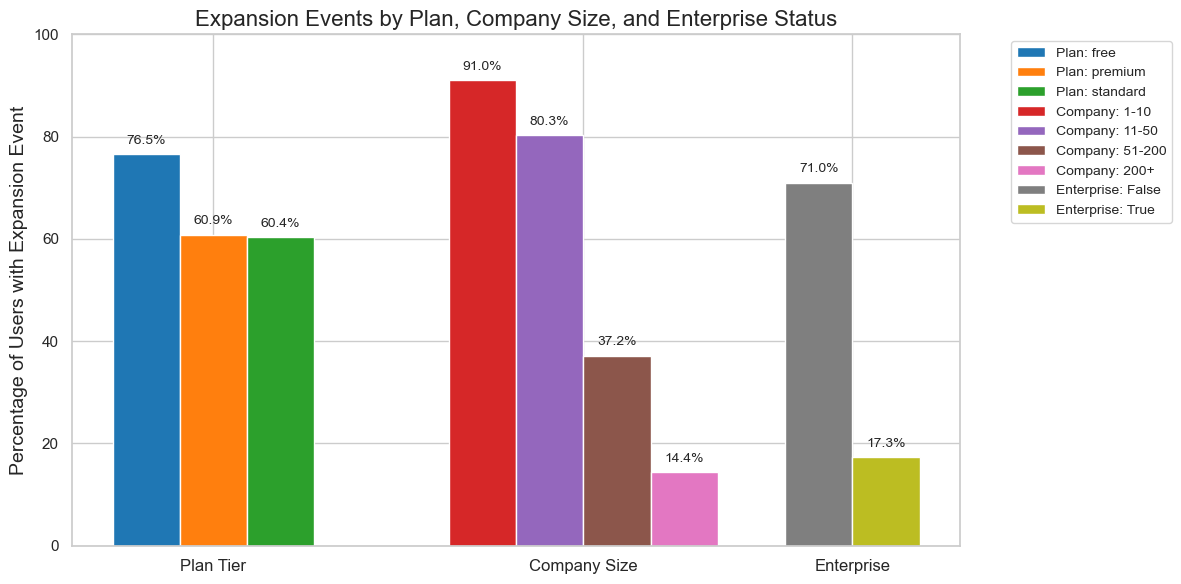

In [17]:
## INSIGHT FOUR: Expansion Events
# Dataset
df_exp = user_features_30d.copy()
company_order = ['1-10', '11-50', '51-200', '200+']
df_exp['company_size'] = pd.Categorical(df_exp['company_size'], categories=company_order, ordered=True)

# Calculate percentages
plan_props = df_exp.groupby('plan_tier')['expansion_event'].mean() * 100
company_props = df_exp.groupby('company_size')['expansion_event'].mean() * 100
enterprise_props = df_exp.groupby('is_enterprise')['expansion_event'].mean() * 100

# Plot setup
fig, ax = plt.subplots(figsize=(12,6))
clusters = [0, 1, 2]  # positions for clusters
width = 0.2

# Colors
plan_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # 3 plan tiers
company_colors = ['#d62728', '#9467bd', '#8c564b', '#e377c2']  # 4 company sizes
enterprise_colors = ['#7f7f7f', '#bcbd22']  # True/False

# Plot plan_tier
for i, val in enumerate(plan_props):
    ax.bar(clusters[0] + i*width, val, width=width, color=plan_colors[i], label=f'Plan: {plan_props.index[i]}')

# Plot company_size
for i, val in enumerate(company_props):
    ax.bar(clusters[1] + i*width, val, width=width, color=company_colors[i], label=f'Company: {company_props.index[i]}')

# Plot enterprise
for i, val in enumerate(enterprise_props):
    ax.bar(clusters[2] + i*width, val, width=width, color=enterprise_colors[i], label=f'Enterprise: {enterprise_props.index[i]}')

# Center x-axis labels under clusters
cluster_centers = [clusters[0] + (len(plan_props)-1)/2*width,
                   clusters[1] + (len(company_props)-1)/2*width,
                   clusters[2] + (len(enterprise_props)-1)/2*width]
ax.set_xticks(cluster_centers)
ax.set_xticklabels(['Plan Tier', 'Company Size', 'Enterprise'], fontsize=12)

# Y-axis
ax.set_ylabel('Percentage of Users with Expansion Event', fontsize=14)
ax.set_ylim(0, 100)
ax.set_title('Expansion Events by Plan, Company Size, and Enterprise Status', fontsize=16)

# Data labels
for i, val in enumerate(plan_props):
    ax.text(clusters[0] + i*width, val + 2, f'{val:.1f}%', ha='center', fontsize=10)
for i, val in enumerate(company_props):
    ax.text(clusters[1] + i*width, val + 2, f'{val:.1f}%', ha='center', fontsize=10)
for i, val in enumerate(enterprise_props):
    ax.text(clusters[2] + i*width, val + 2, f'{val:.1f}%', ha='center', fontsize=10)

# Legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()


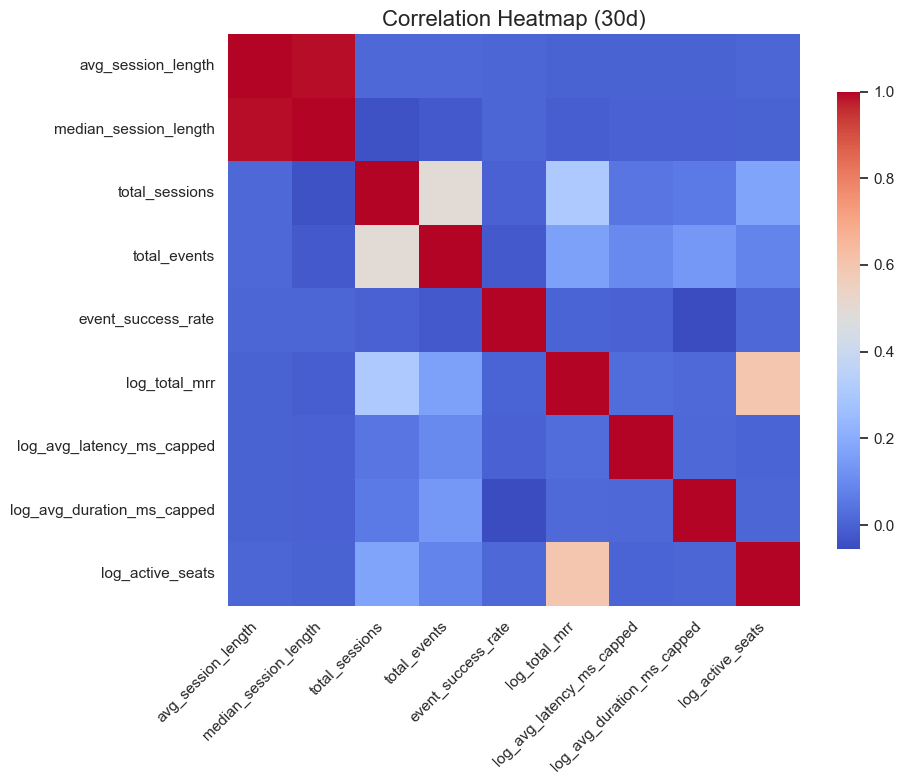

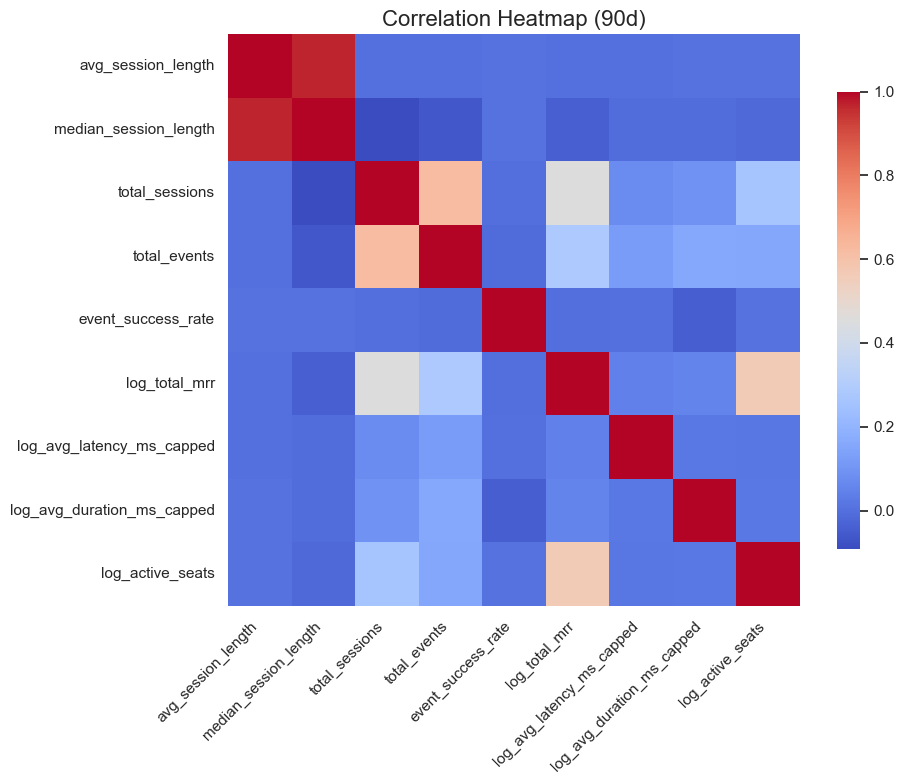

In [18]:
### Correlation Heatmaps
# Copy datasets
df_30d_corr = user_features_30d.copy()
df_90d_corr = user_features_90d.copy()

# ---------------------------
# Log-transform skewed features (if not already done)
log_features = ['total_mrr', 'avg_latency_ms_capped', 'avg_duration_ms_capped', 'active_seats']

for df in [df_30d_corr, df_90d_corr]:
    for col in log_features:
        if col in df.columns and f'log_{col}' not in df.columns:
            df[f'log_{col}'] = np.log1p(df[col])

# ---------------------------
# Select numeric features safely
numeric_features_base = [
    'avg_session_length', 'median_session_length', 'total_sessions',
    'total_events', 'event_success_rate'
]

# Add the log-transformed ones if present
numeric_features = numeric_features_base + [f'log_{col}' for col in log_features]

# Keep only columns that exist in the current dataframe
numeric_features_30d = [col for col in numeric_features if col in df_30d_corr.columns]
numeric_features_90d = [col for col in numeric_features if col in df_90d_corr.columns]

# ---------------------------
# Correlation heatmaps (color only, no numbers)
for df, label, num_feats in zip([df_30d_corr, df_90d_corr],
                                ['30d', '90d'],
                                [numeric_features_30d, numeric_features_90d]):
    corr_matrix = df[num_feats].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(
        corr_matrix,
        annot=False,     # <- no numbers
        cmap="coolwarm",
        square=True,
        cbar_kws={'shrink':0.8}
    )
    plt.title(f'Correlation Heatmap ({label})', fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

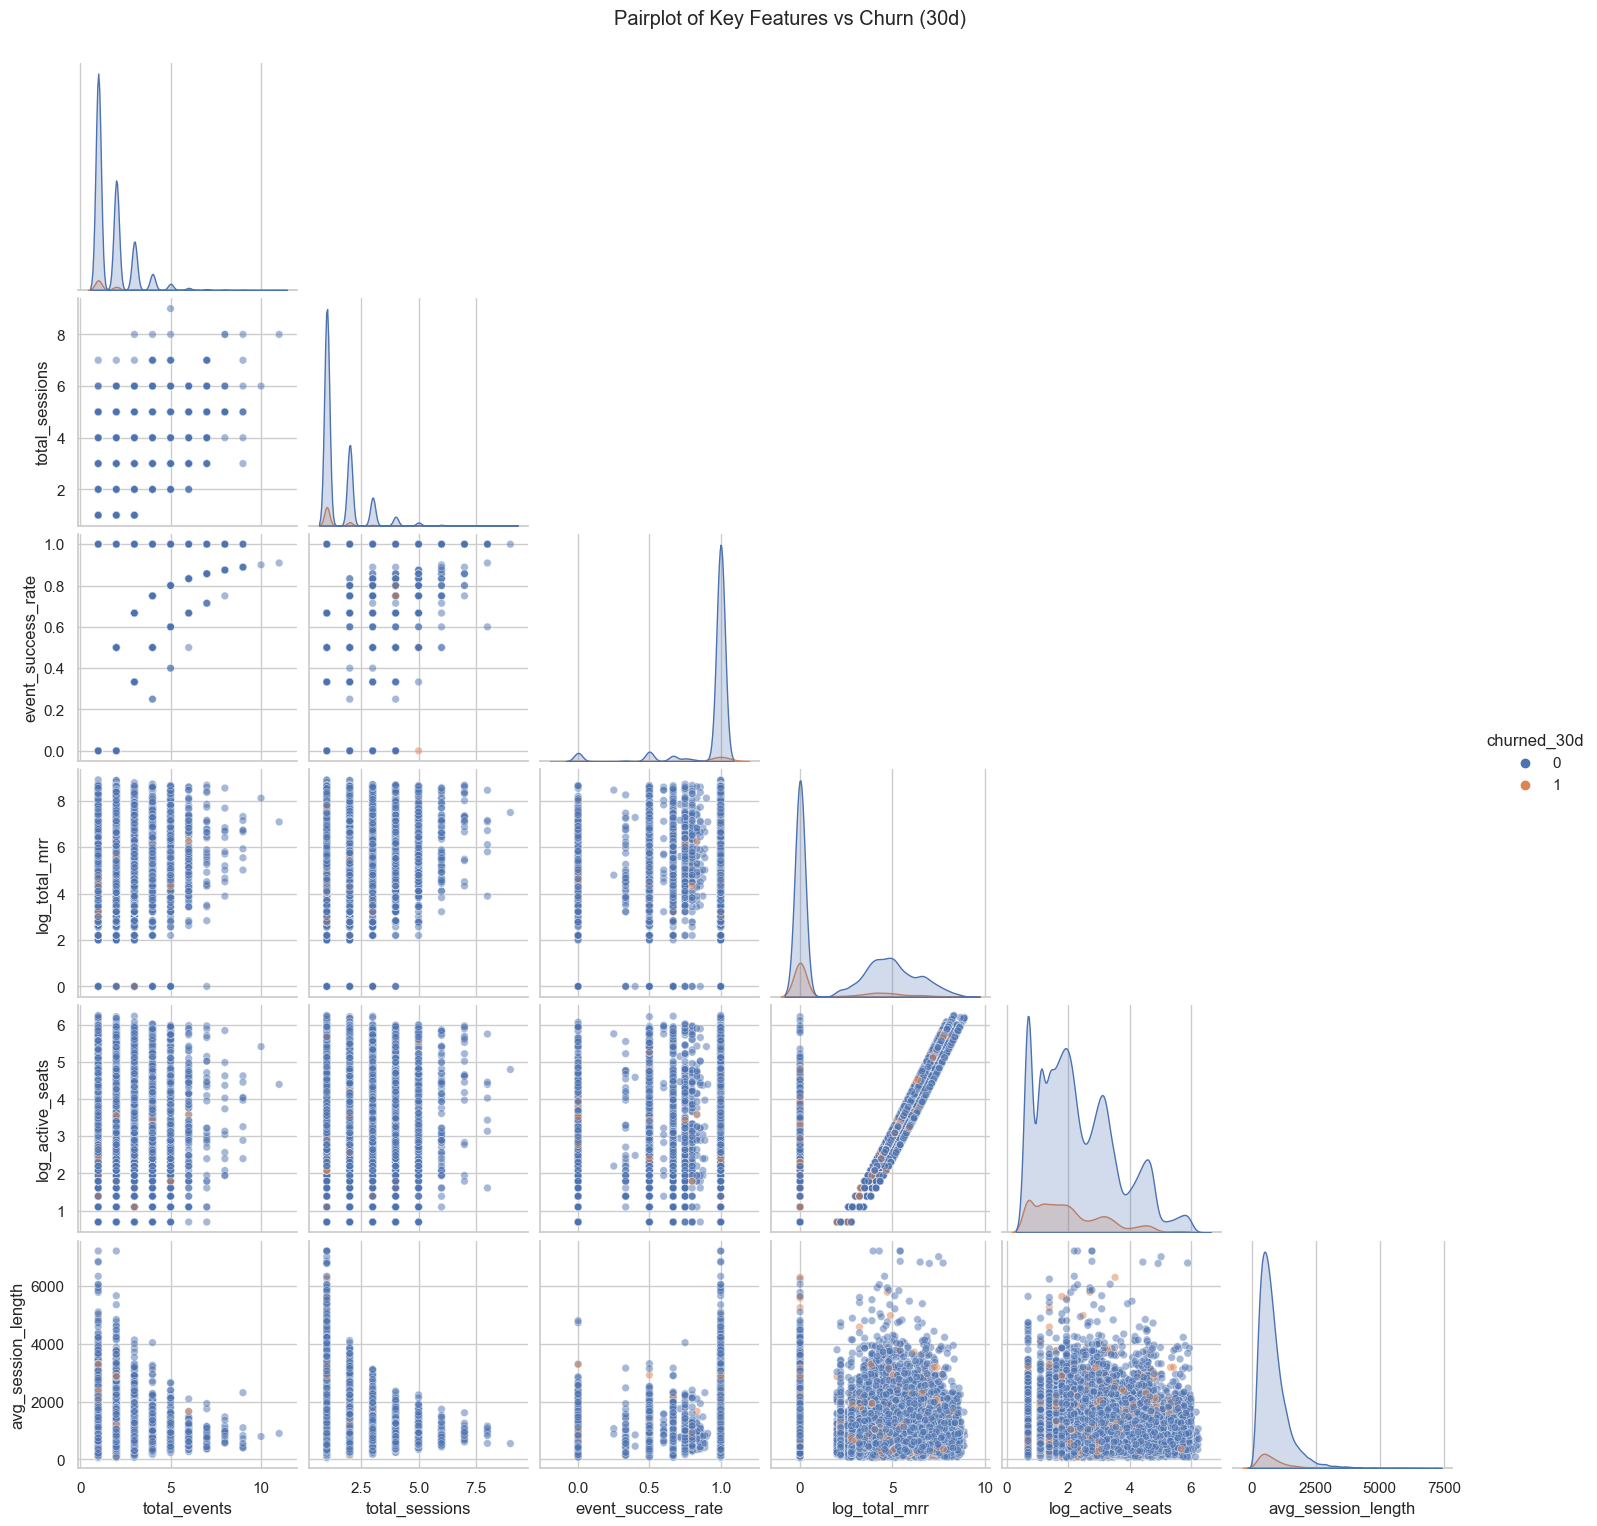

C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Arum Titan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

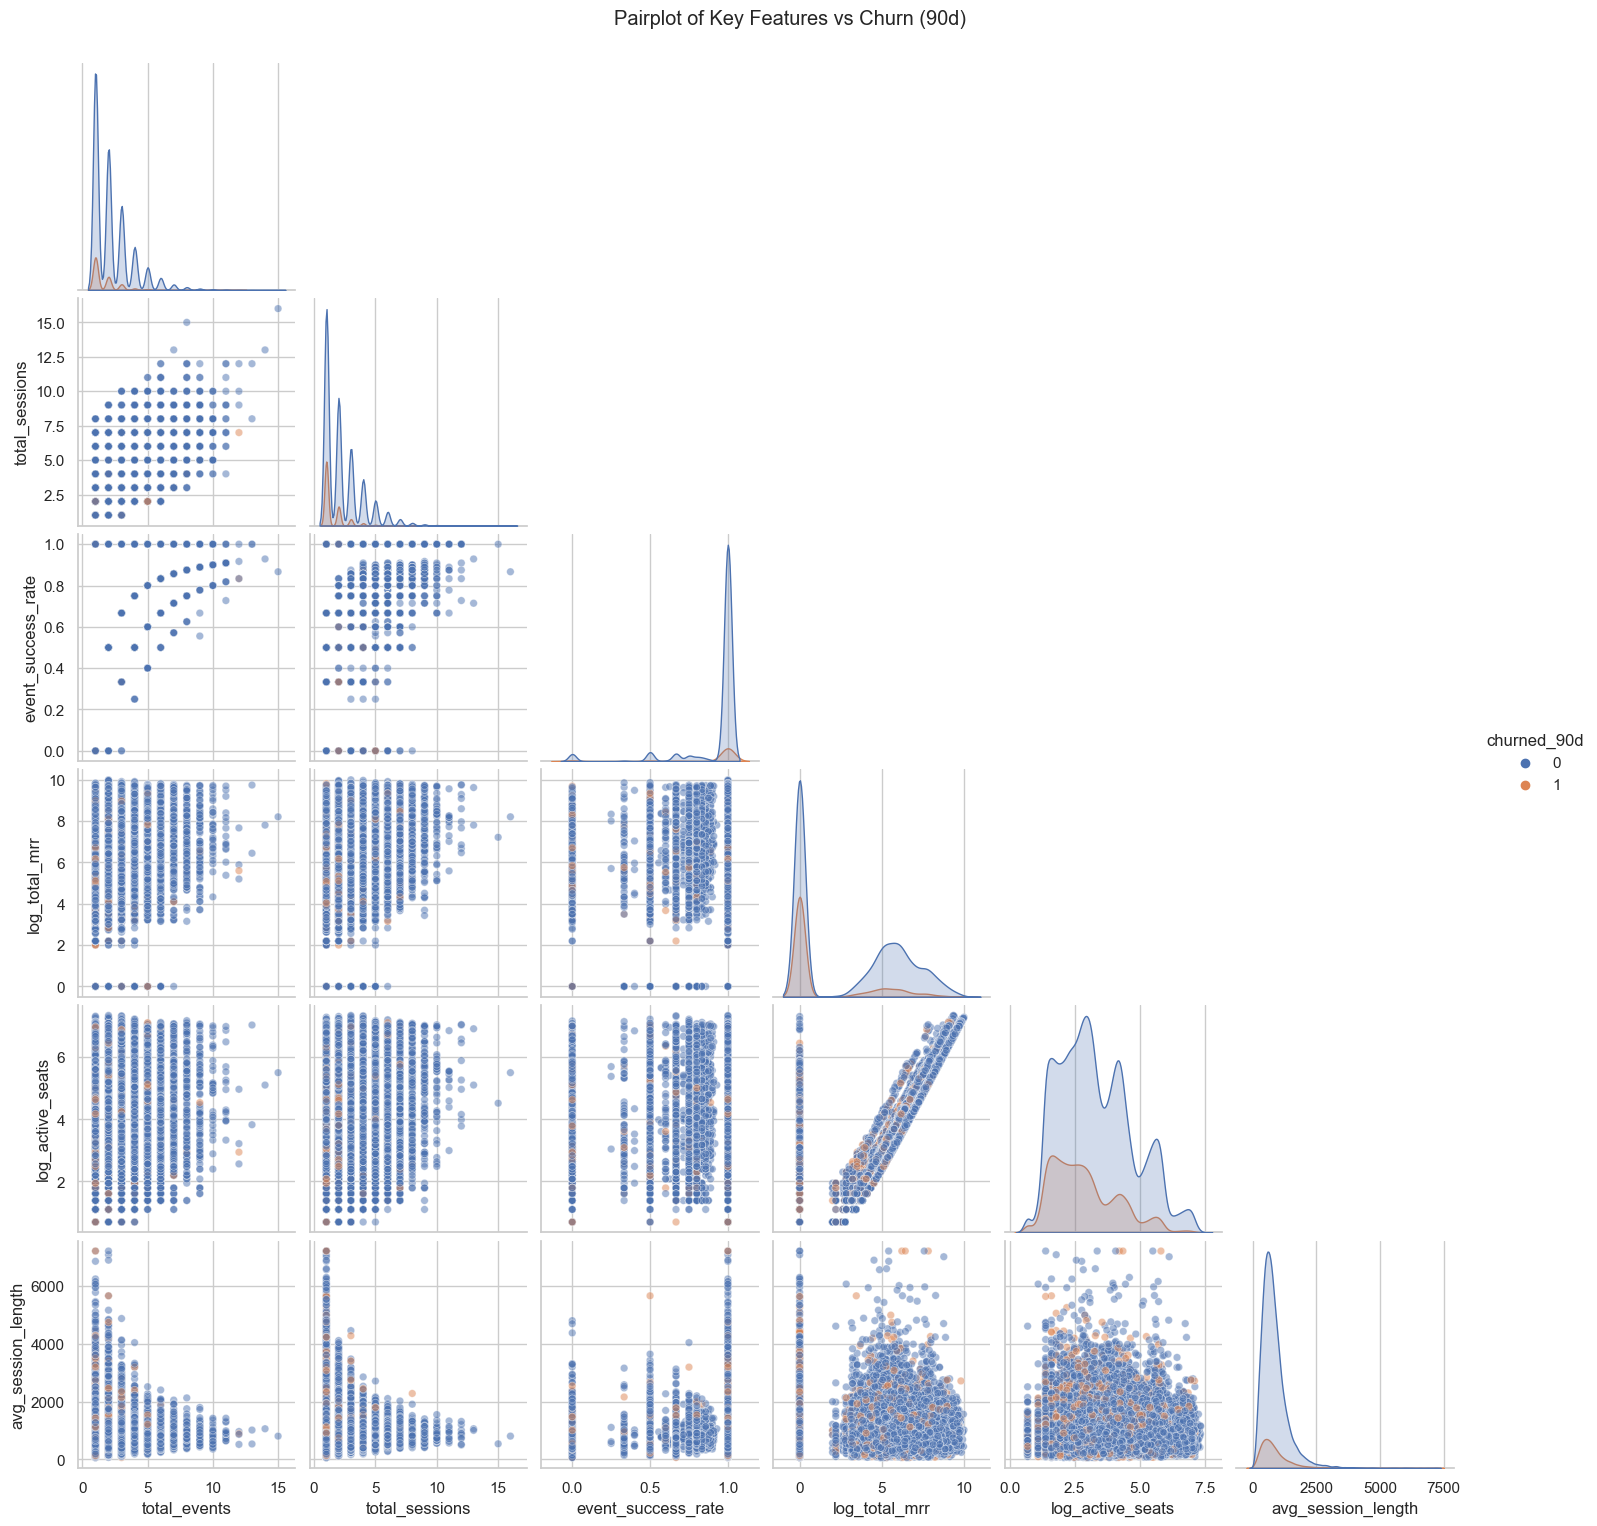

In [21]:
### Pairplots Against Churn 
pairplot_features = [
    'total_events',
    'total_sessions',
    'event_success_rate', 
    'log_total_mrr', 
    'log_active_seats',
    'avg_session_length'
]

# filter only features that exist
pairplot_features_30d = [f for f in pairplot_features if f in df_30d_corr.columns]

sns.pairplot(
    df_30d_corr[pairplot_features_30d + ['churned_30d']], 
    hue='churned_30d',
    corner=True, 
    plot_kws={'alpha':0.5, 's':30}  # lighter points, smaller markers
)
plt.suptitle('Pairplot of Key Features vs Churn (30d)', y=1.02)
plt.show()


# filter only features that exist in 90d df
pairplot_features_90d = [f for f in pairplot_features if f in df_90d_corr.columns]

sns.pairplot(
    df_90d_corr[pairplot_features_90d + ['churned_90d']], 
    hue='churned_90d',
    corner=True, 
    plot_kws={'alpha':0.5, 's':30}
)
plt.suptitle('Pairplot of Key Features vs Churn (90d)', y=1.02)
plt.show()


In [79]:
# ---------------------------
# Baseline Logistic Regression (Refactored)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

# ---------------------------
# Targets
target_30d = 'churned_30d'
target_90d = 'churned_90d'

# ---------------------------
# Numeric & categorical features
numeric_features = [
    'total_sessions', 'avg_session_length', 'median_session_length', 'active_days',
    'num_unique_devices', 'num_unique_os', 'sessions_per_active_day',
    'days_since_signup_to_first_session', 'avg_session_start_hour', 'weekend_usage_ratio',
    'total_events', 'event_success_rate', 'events_per_session',
    'gini_feature_usage', 'top_feature_share',
    'total_mrr', 'active_seats', 'seats_per_active_day',
    'support_ticket_count', 'discount_applied_ratio'
]

log_transform_features = [
    'total_mrr', 
    'avg_latency_ms_capped', 
    'avg_duration_ms_capped', 
    'active_seats'
]

categorical_features = [
    'plan_tier', 'region', 'acquisition_channel', 'is_enterprise', 'company_size'
]

# ---------------------------
def prepare_features(df, numeric_features, log_features, categorical_features):
    df_proc = df.copy()
    numeric_features_proc = [f for f in numeric_features if f in df_proc.columns]
    
    # Log-transform skewed features
    for col in log_features:
        if col in df_proc.columns:
            df_proc[f'log_{col}'] = np.log1p(df_proc[col])
            if col in numeric_features_proc:
                numeric_features_proc.remove(col)
            numeric_features_proc.append(f'log_{col}')
    
    categorical_features_proc = [f for f in categorical_features if f in df_proc.columns]
    
    X = df_proc[numeric_features_proc + categorical_features_proc]
    return X, numeric_features_proc, categorical_features_proc

# ---------------------------
def run_logistic_regression(df, target, numeric_features, log_features, categorical_features, smote=False):
    X, numeric_proc, categorical_proc = prepare_features(df, numeric_features, log_features, categorical_features)
    y = df[target]
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Preprocessing
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_proc),
        ('cat', categorical_transformer, categorical_proc)
    ])
    
    # Preprocess train/test
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
    
    # Optionally apply SMOTE
    if smote:
        sm = SMOTE(random_state=42)
        X_train_proc, y_train = sm.fit_resample(X_train_proc, y_train)
    
    # Logistic Regression
    clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    clf.fit(X_train_proc, y_train)
    
    # Predictions
    y_pred_proba = clf.predict_proba(X_test_proc)[:, 1]
    y_pred_default = (y_pred_proba >= 0.5).astype(int)
    
    # Metrics
    print(f"=== Logistic Regression metrics for {target} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_default))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_default))
    
    # Feature importance
    feature_names = preprocessor.get_feature_names_out()
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': clf.coef_[0]
    }).sort_values(by='coefficient', key=abs, ascending=False)
    
    print("\nTop features by absolute coefficient:")
    display(coef_df.head(30))
    
    return clf, preprocessor, X_train_proc, X_test_proc, y_train, y_test, y_pred_proba

# ---------------------------
# Run for 30d churn
clf_30d, preproc_30d, X_train_30d, X_test_30d, y_train_30d, y_test_30d, y_pred_proba_30d = \
    run_logistic_regression(user_features_30d, target_30d, numeric_features, log_transform_features, categorical_features, smote=True)

# ---------------------------
# Run for 90d churn
clf_90d, preproc_90d, X_train_90d, X_test_90d, y_train_90d, y_test_90d, y_pred_proba_90d = \
    run_logistic_regression(user_features_90d, target_90d, numeric_features, log_transform_features, categorical_features, smote=True)


C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


=== Logistic Regression metrics for churned_30d ===
Accuracy: 0.48673333333333335
ROC-AUC: 0.6201612019590822

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.45      0.60     26112
           1       0.17      0.73      0.27      3888

    accuracy                           0.49     30000
   macro avg       0.54      0.59      0.44     30000
weighted avg       0.82      0.49      0.56     30000


Top features by absolute coefficient:


,feature,coefficient
20,cat__plan_tier_premium,-0.882739
21,cat__plan_tier_standard,-0.469748
2,num__median_session_length,-0.467500
1,num__avg_session_length,0.435366
0,num__total_sessions,-0.370712
30,cat__company_size_200+,-0.268130
31,cat__company_size_51-200,-0.260840
8,num__total_events,-0.171681
17,num__log_avg_latency_ms_capped,0.155682
13,num__seats_per_active_day,-0.116812


C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


=== Logistic Regression metrics for churned_90d ===
Accuracy: 0.5722333333333334
ROC-AUC: 0.6910352770381902

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.50      0.64     23102
           1       0.33      0.80      0.46      6898

    accuracy                           0.57     30000
   macro avg       0.61      0.65      0.55     30000
weighted avg       0.76      0.57      0.60     30000


Top features by absolute coefficient:


,feature,coefficient
20,cat__plan_tier_premium,-1.307583
21,cat__plan_tier_standard,-0.700182
11,num__gini_feature_usage,0.541813
4,num__num_unique_os,-0.462701
30,cat__company_size_200+,-0.360730
31,cat__company_size_51-200,-0.252873
28,cat__is_enterprise_True,-0.247775
12,num__top_feature_share,-0.185591
8,num__total_events,0.180828
17,num__log_avg_latency_ms_capped,0.150878


In [90]:
def evaluate_threshold(y_test, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    print(f"=== Metrics at threshold {threshold} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))  # AUC is independent of threshold
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    return y_pred

# 30d
y_pred_30d_default = evaluate_threshold(y_test_30d, y_pred_proba_30d, threshold=0.5)
y_pred_30d_tuned   = evaluate_threshold(y_test_30d, y_pred_proba_30d, threshold=0.55)

# 90d
y_pred_90d_default = evaluate_threshold(y_test_90d, y_pred_proba_90d, threshold=0.5)
y_pred_90d_tuned   = evaluate_threshold(y_test_90d, y_pred_proba_90d, threshold=0.55)

=== Metrics at threshold 0.5 ===
Accuracy: 0.48673333333333335
ROC-AUC: 0.6201612019590822

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.45      0.60     26112
           1       0.17      0.73      0.27      3888

    accuracy                           0.49     30000
   macro avg       0.54      0.59      0.44     30000
weighted avg       0.82      0.49      0.56     30000

=== Metrics at threshold 0.55 ===
Accuracy: 0.5759666666666666
ROC-AUC: 0.6201612019590822

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.57      0.70     26112
           1       0.17      0.59      0.27      3888

    accuracy                           0.58     30000
   macro avg       0.54      0.58      0.48     30000
weighted avg       0.81      0.58      0.65     30000

=== Metrics at threshold 0.5 ===
Accuracy: 0.5722333333333334
ROC-AUC: 0.6910352770381902

Classification Report:


In [114]:
# ---------------------------
# Random Forest Classifier Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

def run_random_forest(df, target, numeric_features, log_features, categorical_features, smote=False):
    X, numeric_proc, categorical_proc = prepare_features(df, numeric_features, log_features, categorical_features)
    y = df[target]
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Preprocessing
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())   # not strictly needed for trees but keeps parity
    ])
    categorical_transformer = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_proc),
        ('cat', categorical_transformer, categorical_proc)
    ])
    
    # Preprocess
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
    
    # Optionally apply SMOTE
    if smote:
        sm = SMOTE(random_state=42)
        X_train_proc, y_train = sm.fit_resample(X_train_proc, y_train)
    
    # Random Forest Classifier
    clf = RandomForestClassifier(
        n_estimators=300,       # more trees for stability
        max_depth=None,         # let it grow, but prevent overfit via min_samples_split
        min_samples_split=5,
        min_samples_leaf=3,
        class_weight="balanced", # handle imbalance directly
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train_proc, y_train)
    
    # Predictions
    y_pred_proba = clf.predict_proba(X_test_proc)[:, 1]
    y_pred_default = (y_pred_proba >= 0.5).astype(int)
    
    # Metrics
    print(f"=== Random Forest metrics for {target} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_default))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("\nClassification Report (default 0.5 threshold):\n", classification_report(y_test, y_pred_default))
    
    # Feature importance
    feature_names = preprocessor.get_feature_names_out()
    importances = clf.feature_importances_
    feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_imp = feat_imp.sort_values(by='importance', ascending=False)
    
    print("\nTop features by importance:")
    display(feat_imp.head(30))
    
    return clf, preprocessor, X_train_proc, X_test_proc, y_train, y_test, y_pred_proba

# ---------------------------
# Run for 30d churn
rf_30d, preproc_rf_30d, X_train_rf_30d, X_test_rf_30d, y_train_rf_30d, y_test_rf_30d, y_pred_proba_rf_30d = \
    run_random_forest(user_features_30d, target_30d, numeric_features, log_transform_features, categorical_features, smote=True)

# ---------------------------
# Run for 90d churn
rf_90d, preproc_rf_90d, X_train_rf_90d, X_test_rf_90d, y_train_rf_90d, y_test_rf_90d, y_pred_proba_rf_90d = \
    run_random_forest(user_features_90d, target_90d, numeric_features, log_transform_features, categorical_features, smote=True)

# ---------------------------
# Evaluate thresholds for F1 optimization
print("\n--- Threshold Tuning: 30d ---")
for t in [0.4, 0.45, 0.5, 0.55]:
    evaluate_threshold(y_test_rf_30d, y_pred_proba_rf_30d, threshold=t)

print("\n--- Threshold Tuning: 90d ---")
for t in [0.4, 0.45, 0.5, 0.55]:
    evaluate_threshold(y_test_rf_90d, y_pred_proba_rf_90d, threshold=t)


C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


=== Random Forest metrics for churned_30d ===
Accuracy: 0.49816666666666665
ROC-AUC: 0.6009894698620188

Classification Report (default 0.5 threshold):
               precision    recall  f1-score   support

           0       0.91      0.47      0.62     26112
           1       0.16      0.69      0.26      3888

    accuracy                           0.50     30000
   macro avg       0.54      0.58      0.44     30000
weighted avg       0.81      0.50      0.57     30000


Top features by importance:


,feature,importance
0,cat__plan_tier_premium,0.430479
1,cat__plan_tier_standard,0.214911
8,cat__is_enterprise_True,0.066843
10,cat__company_size_200+,0.050169
11,cat__company_size_51-200,0.042804
5,cat__acquisition_channel_outbound,0.033447
4,cat__region_unknown,0.031001
2,cat__region_EU,0.029779
7,cat__acquisition_channel_seo,0.027536
3,cat__region_LATAM,0.026155


C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


=== Random Forest metrics for churned_90d ===
Accuracy: 0.5716333333333333
ROC-AUC: 0.6630764999743094

Classification Report (default 0.5 threshold):
               precision    recall  f1-score   support

           0       0.88      0.52      0.65     23102
           1       0.32      0.76      0.45      6898

    accuracy                           0.57     30000
   macro avg       0.60      0.64      0.55     30000
weighted avg       0.75      0.57      0.60     30000


Top features by importance:


,feature,importance
0,cat__plan_tier_premium,0.535388
1,cat__plan_tier_standard,0.311241
8,cat__is_enterprise_True,0.056832
10,cat__company_size_200+,0.022664
11,cat__company_size_51-200,0.021575
9,cat__company_size_11-50,0.008606
7,cat__acquisition_channel_seo,0.008073
4,cat__region_unknown,0.007912
6,cat__acquisition_channel_partner,0.007767
2,cat__region_EU,0.006983



--- Threshold Tuning: 30d ---
=== Metrics at threshold 0.4 ===
Accuracy: 0.33576666666666666
ROC-AUC: 0.6009894698620188

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.26      0.40     26112
           1       0.15      0.87      0.25      3888

    accuracy                           0.34     30000
   macro avg       0.54      0.56      0.33     30000
weighted avg       0.83      0.34      0.38     30000

=== Metrics at threshold 0.45 ===
Accuracy: 0.40536666666666665
ROC-AUC: 0.6009894698620188

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.35      0.50     26112
           1       0.15      0.80      0.26      3888

    accuracy                           0.41     30000
   macro avg       0.54      0.57      0.38     30000
weighted avg       0.82      0.41      0.47     30000

=== Metrics at threshold 0.5 ===
Accuracy: 0.49816666666666665
ROC-AUC: 0.60098946

In [118]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 1.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.5 MB 2.1 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.5 MB 3.0 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.5 MB 3.0 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.5 MB 3.0 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 1.7 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 1.7 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 1.7 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 1.1 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 1.1 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.5 MB 949.4 kB/s eta 0:00:02
   ------------ --------------------------- 0.5/1.5 MB 853.3 kB/s eta 0:00:02
   ------------

In [122]:
# ---------------------------
# LightGBM for Phase 1 features
import lightgbm as lgb
from sklearn.metrics import f1_score

def run_lightgbm_phase1(df, target, numeric_features, log_features, categorical_features,
                        smote=True, thresholds=np.arange(0.3, 0.7, 0.05)):
    
    X, numeric_proc, categorical_proc = prepare_features(df, numeric_features, log_features, categorical_features)
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Preprocessing
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_proc),
        ('cat', categorical_transformer, categorical_proc)
    ])

    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)

    # SMOTE
    if smote:
        sm = SMOTE(random_state=42)
        X_train_proc, y_train = sm.fit_resample(X_train_proc, y_train)

    # LightGBM
    clf = lgb.LGBMClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train_proc, y_train)

    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test_proc)[:,1]

    # Find threshold maximizing F1
    best_thresh, best_f1 = 0.5, 0
    for thresh in thresholds:
        y_pred = (y_pred_proba >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh

    # Final predictions
    y_pred_final = (y_pred_proba >= best_thresh).astype(int)

    print(f"=== LightGBM metrics for {target} ===")
    print(f"Best threshold (max F1): {best_thresh:.2f}")
    print("F1 Score:", f1_score(y_test, y_pred_final))
    print("Accuracy:", accuracy_score(y_test, y_pred_final))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

    # Feature importance
    feature_names = preprocessor.get_feature_names_out()
    fi_df = pd.DataFrame({
        'feature': feature_names,
        'importance': clf.booster_.feature_importance(importance_type='gain')
    }).sort_values(by='importance', ascending=False)
    print("\nTop features by importance:")
    display(fi_df.head(20))

    return clf, preprocessor, X_train_proc, X_test_proc, y_train, y_test, y_pred_proba, best_thresh

# ---------------------------
# Run LightGBM for both 30d and 90d churn

targets = ['churned_30d', 'churned_90d']

results = {}

for target in targets:
    print(f"\n******** Running LightGBM for {target} ********\n")
    clf, preproc, X_train_proc, X_test_proc, y_train, y_test, y_pred_proba, best_thresh = \
        run_lightgbm_phase1(
            df=user_features_30d if target=='churned_30d' else user_features_90d,
            target=target,
            numeric_features=numeric_features,
            log_features=log_transform_features,
            categorical_features=categorical_features,
            smote=True
        )
    results[target] = {
        'model': clf,
        'preprocessor': preproc,
        'X_train': X_train_proc,
        'X_test': X_test_proc,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred_proba': y_pred_proba,
        'best_threshold': best_thresh
    }



******** Running LightGBM for churned_30d ********



C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 60927, number of negative: 60927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 121854, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
=== LightGBM metrics for churned_30d ===
Best threshold (max F1): 0.50
F1 Score: 0.26172050526736235
Accuracy: 0.5071
ROC-AUC: 0.6010973070105099

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.48      0.63     26112
           1       0.16      0.67      0.26      3888

    accuracy                           0.51     30000
   macro avg       0.54      0.58      0.45     30000
weighted avg       0.81      0.51      0.58     30000


,feature,importance
0,cat__plan_tier_premium,30004.718607
1,cat__plan_tier_standard,20323.963459
10,cat__company_size_200+,5232.069792
11,cat__company_size_51-200,3763.803839
5,cat__acquisition_channel_outbound,3268.511536
8,cat__is_enterprise_True,3085.081364
4,cat__region_unknown,3002.187490
7,cat__acquisition_channel_seo,2795.368686
2,cat__region_EU,2580.826801
6,cat__acquisition_channel_partner,2240.075458



******** Running LightGBM for churned_90d ********



C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 53906, number of negative: 53906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 107812, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
=== LightGBM metrics for churned_90d ===
Best threshold (max F1): 0.50
F1 Score: 0.44890432694369403
Accuracy: 0.5716333333333333
ROC-AUC: 0.6631920576914325

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.52      0.65     23102
           1       0.32      0.76      0.45      6898

    accuracy                           0.57     30000
   macro avg       0.60      0.64      0.55     30000
weighted avg       0.75      0.57      0.60

,feature,importance
0,cat__plan_tier_premium,60148.394795
1,cat__plan_tier_standard,46689.616612
10,cat__company_size_200+,4437.879888
11,cat__company_size_51-200,3067.777326
8,cat__is_enterprise_True,1901.727350
6,cat__acquisition_channel_partner,1603.098278
9,cat__company_size_11-50,1501.966585
7,cat__acquisition_channel_seo,1171.824151
4,cat__region_unknown,1144.754746
3,cat__region_LATAM,1107.840846


In [123]:
## PHASE 2: ADVANCED FEATURES
def create_advanced_features(users, sessions, events, billing):
    df = users.copy()

    # ---------------------------
    # Sessions-based features
    sessions['session_length_min'] = sessions['session_length_sec'] / 60
    session_agg = sessions.groupby('user_id').agg(
        total_sessions=('session_id', 'count'),
        avg_session_length=('session_length_min', 'mean'),
        median_session_length=('session_length_min', 'median'),
        active_days=('session_start', lambda x: x.dt.date.nunique())
    ).reset_index()
    df = df.merge(session_agg, on='user_id', how='left')

    # Plan-tier level aggregations
    plan_agg = df.groupby('plan_tier').agg(
        avg_sessions_per_day_by_plan=('total_sessions', lambda x: x.sum()/x.count()),
        avg_session_length_by_plan=('avg_session_length', 'mean')
    ).reset_index()
    df = df.merge(plan_agg, on='plan_tier', how='left')

    # Company-size level aggregations
    size_agg = df.groupby('company_size').agg(
        avg_sessions_per_user_by_size=('total_sessions', 'mean'),
        avg_active_days_by_size=('active_days', 'mean')
    ).reset_index()
    df = df.merge(size_agg, on='company_size', how='left')

    # ---------------------------
    # Billing-based features
    billing_agg = billing.groupby('user_id').agg(
        total_mrr=('mrr', 'sum'),
        active_seats=('active_seats', 'mean'),
        seat_growth_rate=('active_seats', lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0] if len(x) > 1 else 0),
        support_ticket_count=('support_ticket_count', 'sum')
    ).reset_index()
    df = df.merge(billing_agg, on='user_id', how='left')

    # Per-seat ratios
    df['mrr_per_seat'] = df['total_mrr'] / (df['active_seats'] + 1e-5)
    df['support_per_seat'] = df['support_ticket_count'] / (df['active_seats'] + 1e-5)

    # ---------------------------
    # Events-based features
    event_agg = events.groupby('user_id').agg(
        total_events=('event_id', 'count'),
        event_success_rate=('success', 'mean'),
        feature_diversity=('feature_name', 'nunique')
    ).reset_index()
    df = df.merge(event_agg, on='user_id', how='left')

    # ---------------------------
    # Interaction features
    df['plan_size_interaction'] = df['plan_tier'].astype(str) + "_" + df['company_size'].astype(str)
    df['seat_mrr_ratio'] = df['active_seats'] / (df['total_mrr'] + 1e-5)
    df['sessions_per_event'] = df['total_sessions'] / (df['total_events'] + 1e-5)

    # Fill NaNs
    df.fillna(0, inplace=True)
    
    return df

# Usage
user_features_adv = create_advanced_features(users, sessions, events, billing)


In [124]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# ---------------------------
def prepare_features_adv(df, numeric_features, categorical_features):
    df_proc = df.copy()
    numeric_proc = [f for f in numeric_features if f in df_proc.columns]
    categorical_proc = [f for f in categorical_features if f in df_proc.columns]
    X = df_proc[numeric_proc + categorical_proc]
    return X, numeric_proc, categorical_proc

# ---------------------------
def run_lightgbm_adv(df, target, numeric_features, categorical_features, smote=True):
    X, numeric_proc, categorical_proc = prepare_features_adv(df, numeric_features, categorical_features)
    y = df[target]
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Preprocessing
    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])
    categorical_transformer = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_proc),
        ('cat', categorical_transformer, categorical_proc)
    ])
    
    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
    
    # SMOTE
    if smote:
        sm = SMOTE(random_state=42)
        X_train_proc, y_train = sm.fit_resample(X_train_proc, y_train)
    
    # LightGBM dataset
    lgb_train = lgb.Dataset(X_train_proc, label=y_train)
    
    # Model parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'n_estimators': 500,
        'random_state': 42
    }
    
    # Train model
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train_proc, y_train)
    
    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test_proc)[:, 1]
    
    # Optimize threshold for F1
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    for t in thresholds:
        f1_scores.append(f1_score(y_test, (y_pred_proba >= t).astype(int)))
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    
    # Predictions at best threshold
    y_pred_best = (y_pred_proba >= best_threshold).astype(int)
    
    # Metrics
    print(f"=== LightGBM metrics for {target} ===")
    print(f"Best threshold (max F1): {best_threshold:.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_best):.4f}")
    print(f"Accuracy: {np.mean(y_test==y_pred_best):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred_best))
    
    # Feature importance
    feature_names = preprocessor.get_feature_names_out()
    feat_imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    print("\nTop features by importance:")
    display(feat_imp.head(20))
    
    return clf, preprocessor, best_threshold, y_pred_best, y_test, y_pred_proba

# ---------------------------
# Identify numeric & categorical features for advanced features
numeric_features_adv = [
    'total_sessions', 'avg_session_length', 'median_session_length', 'active_days',
    'num_unique_devices', 'num_unique_os', 'sessions_per_active_day',
    'days_since_signup_to_first_session',
    'total_events', 'event_success_rate', 'feature_diversity',
    'total_mrr', 'active_seats', 'seat_growth_rate',
    'mrr_per_seat', 'support_per_seat', 'sessions_per_event'
]

categorical_features_adv = [
    'plan_tier', 'company_size', 'region', 'acquisition_channel', 'is_enterprise', 'plan_size_interaction'
]

# ---------------------------
# Run for 30d churn
clf_30d_adv, preproc_30d_adv, best_thresh_30d, y_pred_30d_adv, y_test_30d_adv, y_pred_proba_30d_adv = \
    run_lightgbm_adv(user_features_adv, 'churned_30d', numeric_features_adv, categorical_features_adv)

# ---------------------------
# Run for 90d churn
clf_90d_adv, preproc_90d_adv, best_thresh_90d, y_pred_90d_adv, y_test_90d_adv, y_pred_proba_90d_adv = \
    run_lightgbm_adv(user_features_adv, 'churned_90d', numeric_features_adv, categorical_features_adv)


C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 60927, number of negative: 60927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6862
[LightGBM] [Info] Number of data points in the train set: 121854, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
=== LightGBM metrics for churned_30d ===
Best threshold (max F1): 0.20
F1 Score: 0.2576
Accuracy: 0.5160
ROC-AUC: 0.5948

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.50      0.64     26112
           1       0.16      0.65      0.26      3888

    accuracy                           0.52     30000
   macro avg       0.53      0.57      0.45     30000
weighted avg       0.81      0.52      0.59     30000


Top features by import

,feature,importance
9,num__seat_growth_rate,3126
8,num__active_seats,2694
11,num__support_per_seat,1243
0,num__total_sessions,781
4,num__total_events,717
1,num__avg_session_length,700
10,num__mrr_per_seat,681
12,num__sessions_per_event,664
2,num__median_session_length,617
3,num__active_days,449


C:\Users\Arum Titan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 53906, number of negative: 53906
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 107812, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
=== LightGBM metrics for churned_90d ===
Best threshold (max F1): 0.27
F1 Score: 0.4451
Accuracy: 0.5639
ROC-AUC: 0.6723

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.51      0.64     23102
           1       0.31      0.76      0.45      6898

    accuracy                           0.56     30000
   macro avg       0.60      0.63      0.54     30000
weighted avg       0.75      0.56      0.60     30000


Top features by import

,feature,importance
9,num__seat_growth_rate,2718
8,num__active_seats,2498
11,num__support_per_seat,1238
1,num__avg_session_length,906
10,num__mrr_per_seat,903
0,num__total_sessions,846
2,num__median_session_length,840
4,num__total_events,693
12,num__sessions_per_event,683
7,num__total_mrr,451
